In [1]:
import requests   
import json
import pprint
import numpy as np
import pandas as pd
from functools import reduce
from pandas.tools.plotting import scatter_matrix
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [2]:
#pd.options.display.max_rows = 3000
pd.options.display.max_columns = 40
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pylab import rcParams


#sns.set(style="ticks")
#sns.set_style("whitegrid")
rcParams['figure.dpi'] = 180
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 7,5
rcParams['font.size'] = 15

### 1.a Static Data

In [3]:
wh = pd.read_excel('WHRData.xls', index_col=0)
wh = wh.reset_index()
wh = wh.rename(columns={'Country name': 'country', 'Year': 'year'})

wh

country  year  Life Ladder  Log GDP per capita  Social support  \
0     Afghanistan  2008     3.723590            7.168690        0.450662   
1     Afghanistan  2009     4.401778            7.333790        0.552308   
2     Afghanistan  2010     4.758381            7.386629        0.539075   
3     Afghanistan  2011     3.831719            7.415019        0.521104   
4     Afghanistan  2012     3.782938            7.517126        0.520637   
5     Afghanistan  2013     3.572100            7.522238        0.483552   
6     Afghanistan  2014     3.130896            7.516955        0.525568   
7     Afghanistan  2015     3.982855            7.500539        0.528597   
8     Afghanistan  2016     4.220169            7.497038        0.559072   
9     Afghanistan  2017     2.661718            7.497755        0.490880   
10    Afghanistan  2018     2.694303            7.494588        0.507516   
11        Albania  2007     4.634252            9.077331        0.821372   
12        Albania  2009     5.485470            9.161638        0.833047   
13        Albania  2010     5.268937            9.203032        0.733152   
14        Albania  2011     5.867422            9.230904        0.759434   
15        Albania  2012     5.510124            9.246655        0.784502   
16        Albania  2013     4.550648            9.258445        0.759477   
17        Albania  2014     4.813763            9.278104        0.625587   
18        Albania  2015     4.606651            9.302960        0.639356   
19        Albania  2016     4.511101            9.337532        0.638411   
20        Albania  2017     4.639548            9.376145        0.637698   
21        Albania  2018     5.004403            9.412399        0.683592   
22        Algeria  2010     5.463567            9.462701             NaN   
23        Algeria  2011     5.317194            9.471962        0.810234   
24        Algeria  2012     5.604596            9.485086        0.839397   
25        Algeria  2014     6.354898            9.509210        0.818189   
26        Algeria  2016     5.340854            9.541166        0.748588   
27        Algeria  2017     5.248912            9.540639        0.806754   
28        Algeria  2018     5.043086            9.557952        0.798651   
29         Angola  2011     5.589001            8.684613        0.723094   
...           ...   ...          ...                 ...             ...   
1674        Yemen  2014     3.967958            8.233982        0.638252   
1675        Yemen  2015     2.982674            7.744412        0.668683   
1676        Yemen  2016     3.825631            7.299221        0.775407   
1677        Yemen  2017     3.253560                 NaN        0.789555   
1678        Yemen  2018     3.057514                 NaN        0.789422   
1679       Zambia  2006     4.824455            7.866006        0.797665   
1680       Zambia  2007     3.998293            7.918941        0.687989   
1681       Zambia  2008     4.730263            7.966175        0.624418   
1682       Zambia  2009     5.260361            8.026193        0.781926   
1683       Zambia  2011     4.999114            8.120028        0.864023   
1684       Zambia  2012     5.013375            8.163204        0.780023   
1685       Zambia  2013     5.243996            8.182191        0.761312   
1686       Zambia  2014     4.345837            8.197678        0.706223   
1687       Zambia  2015     4.843164            8.196217        0.691483   
1688       Zambia  2016     4.347544            8.203072        0.767047   
1689       Zambia  2017     3.932777            8.213179        0.743754   
1690       Zambia  2018     4.041488            8.223958        0.717720   
1691     Zimbabwe  2006     3.826268            7.366704        0.821656   
1692     Zimbabwe  2007     3.280247            7.313939        0.828113   
1693     Zimbabwe  2008     3.174264            7.102516        0.843475   
1694     Zimbabwe  2009     4.055914            7.197595  

### 1.b Dynamic data

In [4]:
class WorldBankDataFetcher:
    """
    """
    
    def __init__(self, indicators):
        self.indicators = indicators
        self.jsons = self.dataframes = []
        self.merged_data = None        

    def fetch_json_by(self, indicator):
        url = "http://api.worldbank.org/v2/countries/all/indicators/%s&format=json&per_page=9000" % (indicator + '?date=2000:2018')
        r = requests.get(url)    
        return json.loads(r.content)

    def json_to_df(self, j):
        indicator_name = j[1][0]['indicator']['value']
        df = pd.DataFrame.from_dict(j[1])
        df['country'] = df[['country']].applymap(lambda x : x['value'])
        df = df[['country', 'countryiso3code', 'date', 'value']]
        df.columns = ['country', 'code', 'year', indicator_name]
        return df
    
    def fetch(self):
        print('Note: this operation make take a while depending on the network status...\n...')      
        
        for i in indicators:
            self.jsons.append(self.fetch_json_by(i))
            progress = str(indicators.index(i)+1) + '/' + str(len(indicators))             
            print(' '.join([progress, 'Indicator', i]))
        
        print('Creating data frames...')
        self.dataframes = [self.json_to_df(j) for j in self.jsons]
        
        print('Merging data frames...')
        self.merged_data = reduce(lambda x, y: x.merge(y, how='outer', on=['country', 'code', 'year']), self.dataframes)        
        
        print('All done!')

In [5]:
indicators = [
    'AG.LND.FRST.K2',    # Forest area (sq. km)    
    'AG.LND.AGRI.ZS',    # Agricultural land (% of land area)
    'EG.ELC.ACCS.ZS',    # Access to electricity (% of population)    
    'EN.ATM.CO2E.PC',    # CO2 emissions (metric tons per capita)
    'MS.MIL.XPND.GD.ZS', # Military expenditure (% of GDP)
    'SL.UEM.TOTL.ZS',    # Unemployment, total (% of total labor force) (modeled ILO estimate)
    'SE.PRM.UNER.FE',    # Children out of school, primary, female
    'SP.POP.TOTL',       # Population, total
    'IS.AIR.DPRT',       # Air transport, registered carrier departures worldwide
    'IC.TAX.TOTL.CP.ZS', # Total tax rate (% of commercial profits)
    'NY.GDP.MKTP.KD.ZG', # GDP growth (annual %)
    'SE.ADT.LITR.ZS'     # Literacy rate, adult total (% of people ages 15 and above)
]

In [6]:
fetcher = WorldBankDataFetcher(indicators)
fetcher.fetch()

Note: this operation make take a while depending on the network status...
...
1/12 Indicator AG.LND.FRST.K2
2/12 Indicator AG.LND.AGRI.ZS
3/12 Indicator EG.ELC.ACCS.ZS
4/12 Indicator EN.ATM.CO2E.PC
5/12 Indicator MS.MIL.XPND.GD.ZS
6/12 Indicator SL.UEM.TOTL.ZS
7/12 Indicator SE.PRM.UNER.FE
8/12 Indicator SP.POP.TOTL
9/12 Indicator IS.AIR.DPRT
10/12 Indicator IC.TAX.TOTL.CP.ZS
11/12 Indicator NY.GDP.MKTP.KD.ZG
12/12 Indicator SE.ADT.LITR.ZS
Creating data frames...
Merging data frames...
All done!


In [7]:
wb = fetcher.merged_data
wb['year'] =  pd.to_numeric(wb['year'])
wb = wb[wb.code!='']
wb = wb.drop('code', axis=1)

wb

country  year  Forest area (sq. km)  \
893   Afghanistan  2018                   NaN   
894   Afghanistan  2017                   NaN   
895   Afghanistan  2016          13500.000000   
896   Afghanistan  2015          13500.000000   
897   Afghanistan  2014          13500.000000   
898   Afghanistan  2013          13500.000000   
899   Afghanistan  2012          13500.000000   
900   Afghanistan  2011          13500.000000   
901   Afghanistan  2010          13500.000000   
902   Afghanistan  2009          13500.000000   
903   Afghanistan  2008          13500.000000   
904   Afghanistan  2007          13500.000000   
905   Afghanistan  2006          13500.000000   
906   Afghanistan  2005          13500.000000   
907   Afghanistan  2004          13500.000000   
908   Afghanistan  2003          13500.000000   
909   Afghanistan  2002          13500.000000   
910   Afghanistan  2001          13500.000000   
911   Afghanistan  2000          13500.000000   
912       Albania  2018                   NaN   
913       Albania  2017                   NaN   
914       Albania  2016           7705.399780   
915       Albania  2015           7715.000000   
916       Albania  2014           7724.600220   
917       Albania  2013           7734.199829   
918       Albania  2012           7743.800049   
919       Albania  2011           7753.400269   
920       Albania  2010           7762.999878   
921       Albania  2009           7775.200195   
922       Albania  2008           7787.399902   
...           ...   ...                   ...   
4986       Zambia  2010         494680.000000   
4987       Zambia  2009         496346.015625   
4988       Zambia  2008         498011.992188   
4989       Zambia  2007         499678.007812   
4990       Zambia  2006         501343.984375   
4991       Zambia  2005         503010.000000   
4992       Zambia  2004         504676.015625   
4993       Zambia  2003         506341.992188   
4994       Zambia  2002         508008.007812   
4995       Zambia  2001         509673.984375   
4996       Zambia  2000         511340.000000   
4997     Zimbabwe  2018                   NaN   
4998     Zimbabwe  2017                   NaN   
4999     Zimbabwe  2016         137495.996094   
5000     Zimbabwe  2015         140620.000000   
5001     Zimbabwe  2014         143744.003906   
5002     Zimbabwe  2013         146867.998047   
5003     Zimbabwe  2012         149992.001953   
5004     Zimbabwe  2011         153115.996094   
5005     Zimbabwe  2010         156240.000000   
5006     Zimbabwe  2009         159510.000000   
5007     Zimbabwe  2008         162780.000000   
5008     Zimbabwe  2007         166050.000000   
5009     Zimbabwe  2006         169320.000000   
5010     Zimbabwe  2005         172590.000000   
5011     Zimbabwe  2004         175860.000000   
5012     Zimbabwe  2003         179130.000000   
5013     Zimbabwe  2002         182400.000000   
5014     Zimbabwe  2001         185670.000000   
5015     Zimbabwe  2000         188940.000000   

      Agricultural land (% of land area)  \
893                                  NaN   
894                                  NaN   
895                            58.067580   
896                            58.067580   
897                            58.067580   
898                            58.067580   
899                            58.067580   
900                            58.067580   
901                            58.069111   
902                            58.067580   
903                            58.067580   
904                            58.067580   
905                            58.067580   
906                            58.067580   
907                            58.069111   
908                            58.067580   
909                            57.827099   
910                            57.827099   
911                            57.827099   
912                                  NaN   
913                                  NaN   
914

### 1.c Integration

In [8]:
country_names = {
    
    'Congo (Brazzaville)' : 'Congo, Rep.',
    
    'Congo (Kinshasa)' : 'Congo, Dem. Rep.',
    
    'Egypt' : 'Egypt, Arab Rep.',
    
    'Gambia': 'Gambia, The',
    
    'Hong Kong S.A.R. of China' : 'Hong Kong SAR, China',
    
    'Iran' : 'Iran, Islamic Rep.',
    
    'Ivory Coast' : "Cote d'Ivoire",
    
    'Kyrgyzstan' : 'Kyrgyz Republic',
    
    'Laos' : 'Lao PDR',
    
    'Macedonia': 'North Macedonia',
    
    'Palestinian Territories' : 'West Bank and Gaza',
    
    'Russia' : 'Russian Federation',
    
    'Slovakia' : 'Slovak Republic',
    
    'South Korea' : 'Korea, Rep.',
        
    'Swaziland': 'Eswatini',
    
    'Syria' : 'Syrian Arab Republic',
    
    'Venezuela' : 'Venezuela, RB',
    
    'Yemen' : 'Yemen, Rep.'
    
}

country_names = {v:k for k, v in country_names.items()}
country_names

{'Congo, Rep.': 'Congo (Brazzaville)',
 'Congo, Dem. Rep.': 'Congo (Kinshasa)',
 'Egypt, Arab Rep.': 'Egypt',
 'Gambia, The': 'Gambia',
 'Hong Kong SAR, China': 'Hong Kong S.A.R. of China',
 'Iran, Islamic Rep.': 'Iran',
 "Cote d'Ivoire": 'Ivory Coast',
 'Kyrgyz Republic': 'Kyrgyzstan',
 'Lao PDR': 'Laos',
 'North Macedonia': 'Macedonia',
 'West Bank and Gaza': 'Palestinian Territories',
 'Russian Federation': 'Russia',
 'Slovak Republic': 'Slovakia',
 'Korea, Rep.': 'South Korea',
 'Eswatini': 'Swaziland',
 'Syrian Arab Republic': 'Syria',
 'Venezuela, RB': 'Venezuela',
 'Yemen, Rep.': 'Yemen'}

In [9]:
set(wh.country).difference(set(wb.country))

{'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Egypt',
 'Gambia',
 'Hong Kong S.A.R. of China',
 'Iran',
 'Ivory Coast',
 'Kyrgyzstan',
 'Laos',
 'Macedonia',
 'North Cyprus',
 'Palestinian Territories',
 'Russia',
 'Slovakia',
 'Somaliland region',
 'South Korea',
 'Swaziland',
 'Syria',
 'Taiwan Province of China',
 'Venezuela',
 'Yemen'}

In [10]:
set(wb.country).difference(set(wh.country))

{'American Samoa',
 'Andorra',
 'Antigua and Barbuda',
 'Aruba',
 'Bahamas, The',
 'Barbados',
 'Bermuda',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Cabo Verde',
 'Cayman Islands',
 'Channel Islands',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Curacao',
 'Dominica',
 'Egypt, Arab Rep.',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'Faroe Islands',
 'Fiji',
 'French Polynesia',
 'Gambia, The',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guam',
 'Guinea-Bissau',
 'Hong Kong SAR, China',
 'Iran, Islamic Rep.',
 'Isle of Man',
 'Kiribati',
 'Korea, Dem. People’s Rep.',
 'Korea, Rep.',
 'Kyrgyz Republic',
 'Lao PDR',
 'Liechtenstein',
 'Macao SAR, China',
 'Maldives',
 'Marshall Islands',
 'Micronesia, Fed. Sts.',
 'Monaco',
 'Nauru',
 'New Caledonia',
 'North Macedonia',
 'Northern Mariana Islands',
 'Palau',
 'Papua New Guinea',
 'Puerto Rico',
 'Russian Federation',
 'Samoa',
 'San Marino',
 'Sao Tome and Principe',
 'Seychelles',
 'Sint Maarten (Dutch part)',
 'S

In [11]:
wb = wb.applymap(lambda x: country_names[x] if x in country_names else x)
wb

country  year  Forest area (sq. km)  \
893   Afghanistan  2018                   NaN   
894   Afghanistan  2017                   NaN   
895   Afghanistan  2016          13500.000000   
896   Afghanistan  2015          13500.000000   
897   Afghanistan  2014          13500.000000   
898   Afghanistan  2013          13500.000000   
899   Afghanistan  2012          13500.000000   
900   Afghanistan  2011          13500.000000   
901   Afghanistan  2010          13500.000000   
902   Afghanistan  2009          13500.000000   
903   Afghanistan  2008          13500.000000   
904   Afghanistan  2007          13500.000000   
905   Afghanistan  2006          13500.000000   
906   Afghanistan  2005          13500.000000   
907   Afghanistan  2004          13500.000000   
908   Afghanistan  2003          13500.000000   
909   Afghanistan  2002          13500.000000   
910   Afghanistan  2001          13500.000000   
911   Afghanistan  2000          13500.000000   
912       Albania  2018                   NaN   
913       Albania  2017                   NaN   
914       Albania  2016           7705.399780   
915       Albania  2015           7715.000000   
916       Albania  2014           7724.600220   
917       Albania  2013           7734.199829   
918       Albania  2012           7743.800049   
919       Albania  2011           7753.400269   
920       Albania  2010           7762.999878   
921       Albania  2009           7775.200195   
922       Albania  2008           7787.399902   
...           ...   ...                   ...   
4986       Zambia  2010         494680.000000   
4987       Zambia  2009         496346.015625   
4988       Zambia  2008         498011.992188   
4989       Zambia  2007         499678.007812   
4990       Zambia  2006         501343.984375   
4991       Zambia  2005         503010.000000   
4992       Zambia  2004         504676.015625   
4993       Zambia  2003         506341.992188   
4994       Zambia  2002         508008.007812   
4995       Zambia  2001         509673.984375   
4996       Zambia  2000         511340.000000   
4997     Zimbabwe  2018                   NaN   
4998     Zimbabwe  2017                   NaN   
4999     Zimbabwe  2016         137495.996094   
5000     Zimbabwe  2015         140620.000000   
5001     Zimbabwe  2014         143744.003906   
5002     Zimbabwe  2013         146867.998047   
5003     Zimbabwe  2012         149992.001953   
5004     Zimbabwe  2011         153115.996094   
5005     Zimbabwe  2010         156240.000000   
5006     Zimbabwe  2009         159510.000000   
5007     Zimbabwe  2008         162780.000000   
5008     Zimbabwe  2007         166050.000000   
5009     Zimbabwe  2006         169320.000000   
5010     Zimbabwe  2005         172590.000000   
5011     Zimbabwe  2004         175860.000000   
5012     Zimbabwe  2003         179130.000000   
5013     Zimbabwe  2002         182400.000000   
5014     Zimbabwe  2001         185670.000000   
5015     Zimbabwe  2000         188940.000000   

      Agricultural land (% of land area)  \
893                                  NaN   
894                                  NaN   
895                            58.067580   
896                            58.067580   
897                            58.067580   
898                            58.067580   
899                            58.067580   
900                            58.067580   
901                            58.069111   
902                            58.067580   
903                            58.067580   
904                            58.067580   
905                            58.067580   
906                            58.067580   
907                            58.069111   
908                            58.067580   
909                            57.827099   
910                            57.827099   
911                            57.827099   
912                                  NaN   
913                                  NaN   
914

In [12]:
set(wh.country).difference(set(wb.country))

{'North Cyprus', 'Somaliland region', 'Taiwan Province of China'}

In [13]:
integrated = wh.merge(wb, how='left', on=['country', 'year'])
integrated

country  year  Life Ladder  Log GDP per capita  Social support  \
0     Afghanistan  2008     3.723590            7.168690        0.450662   
1     Afghanistan  2009     4.401778            7.333790        0.552308   
2     Afghanistan  2010     4.758381            7.386629        0.539075   
3     Afghanistan  2011     3.831719            7.415019        0.521104   
4     Afghanistan  2012     3.782938            7.517126        0.520637   
5     Afghanistan  2013     3.572100            7.522238        0.483552   
6     Afghanistan  2014     3.130896            7.516955        0.525568   
7     Afghanistan  2015     3.982855            7.500539        0.528597   
8     Afghanistan  2016     4.220169            7.497038        0.559072   
9     Afghanistan  2017     2.661718            7.497755        0.490880   
10    Afghanistan  2018     2.694303            7.494588        0.507516   
11        Albania  2007     4.634252            9.077331        0.821372   
12        Albania  2009     5.485470            9.161638        0.833047   
13        Albania  2010     5.268937            9.203032        0.733152   
14        Albania  2011     5.867422            9.230904        0.759434   
15        Albania  2012     5.510124            9.246655        0.784502   
16        Albania  2013     4.550648            9.258445        0.759477   
17        Albania  2014     4.813763            9.278104        0.625587   
18        Albania  2015     4.606651            9.302960        0.639356   
19        Albania  2016     4.511101            9.337532        0.638411   
20        Albania  2017     4.639548            9.376145        0.637698   
21        Albania  2018     5.004403            9.412399        0.683592   
22        Algeria  2010     5.463567            9.462701             NaN   
23        Algeria  2011     5.317194            9.471962        0.810234   
24        Algeria  2012     5.604596            9.485086        0.839397   
25        Algeria  2014     6.354898            9.509210        0.818189   
26        Algeria  2016     5.340854            9.541166        0.748588   
27        Algeria  2017     5.248912            9.540639        0.806754   
28        Algeria  2018     5.043086            9.557952        0.798651   
29         Angola  2011     5.589001            8.684613        0.723094   
...           ...   ...          ...                 ...             ...   
1674        Yemen  2014     3.967958            8.233982        0.638252   
1675        Yemen  2015     2.982674            7.744412        0.668683   
1676        Yemen  2016     3.825631            7.299221        0.775407   
1677        Yemen  2017     3.253560                 NaN        0.789555   
1678        Yemen  2018     3.057514                 NaN        0.789422   
1679       Zambia  2006     4.824455            7.866006        0.797665   
1680       Zambia  2007     3.998293            7.918941        0.687989   
1681       Zambia  2008     4.730263            7.966175        0.624418   
1682       Zambia  2009     5.260361            8.026193        0.781926   
1683       Zambia  2011     4.999114            8.120028        0.864023   
1684       Zambia  2012     5.013375            8.163204        0.780023   
1685       Zambia  2013     5.243996            8.182191        0.761312   
1686       Zambia  2014     4.345837            8.197678        0.706223   
1687       Zambia  2015     4.843164            8.196217        0.691483   
1688       Zambia  2016     4.347544            8.203072        0.767047   
1689       Zambia  2017     3.932777            8.213179        0.743754   
1690       Zambia  2018     4.041488            8.223958        0.717720   
1691     Zimbabwe  2006     3.826268            7.366704        0.821656   
1692     Zimbabwe  2007     3.280247            7.313939        0.828113   
1693     Zimbabwe  2008     3.174264            7.102516        0.843475   
1694     Zimbabwe  2009     4.055914            7.197595  

### 2.a EDA – data quality inspection 

In [14]:
dropped = integrated.dropna(axis='columns', thresh=1500)

print(len(integrated.columns))
print(len(dropped.columns))
dropped

38
21


country  year  Life Ladder  Log GDP per capita  Social support  \
0     Afghanistan  2008     3.723590            7.168690        0.450662   
1     Afghanistan  2009     4.401778            7.333790        0.552308   
2     Afghanistan  2010     4.758381            7.386629        0.539075   
3     Afghanistan  2011     3.831719            7.415019        0.521104   
4     Afghanistan  2012     3.782938            7.517126        0.520637   
5     Afghanistan  2013     3.572100            7.522238        0.483552   
6     Afghanistan  2014     3.130896            7.516955        0.525568   
7     Afghanistan  2015     3.982855            7.500539        0.528597   
8     Afghanistan  2016     4.220169            7.497038        0.559072   
9     Afghanistan  2017     2.661718            7.497755        0.490880   
10    Afghanistan  2018     2.694303            7.494588        0.507516   
11        Albania  2007     4.634252            9.077331        0.821372   
12        Albania  2009     5.485470            9.161638        0.833047   
13        Albania  2010     5.268937            9.203032        0.733152   
14        Albania  2011     5.867422            9.230904        0.759434   
15        Albania  2012     5.510124            9.246655        0.784502   
16        Albania  2013     4.550648            9.258445        0.759477   
17        Albania  2014     4.813763            9.278104        0.625587   
18        Albania  2015     4.606651            9.302960        0.639356   
19        Albania  2016     4.511101            9.337532        0.638411   
20        Albania  2017     4.639548            9.376145        0.637698   
21        Albania  2018     5.004403            9.412399        0.683592   
22        Algeria  2010     5.463567            9.462701             NaN   
23        Algeria  2011     5.317194            9.471962        0.810234   
24        Algeria  2012     5.604596            9.485086        0.839397   
25        Algeria  2014     6.354898            9.509210        0.818189   
26        Algeria  2016     5.340854            9.541166        0.748588   
27        Algeria  2017     5.248912            9.540639        0.806754   
28        Algeria  2018     5.043086            9.557952        0.798651   
29         Angola  2011     5.589001            8.684613        0.723094   
...           ...   ...          ...                 ...             ...   
1674        Yemen  2014     3.967958            8.233982        0.638252   
1675        Yemen  2015     2.982674            7.744412        0.668683   
1676        Yemen  2016     3.825631            7.299221        0.775407   
1677        Yemen  2017     3.253560                 NaN        0.789555   
1678        Yemen  2018     3.057514                 NaN        0.789422   
1679       Zambia  2006     4.824455            7.866006        0.797665   
1680       Zambia  2007     3.998293            7.918941        0.687989   
1681       Zambia  2008     4.730263            7.966175        0.624418   
1682       Zambia  2009     5.260361            8.026193        0.781926   
1683       Zambia  2011     4.999114            8.120028        0.864023   
1684       Zambia  2012     5.013375            8.163204        0.780023   
1685       Zambia  2013     5.243996            8.182191        0.761312   
1686       Zambia  2014     4.345837            8.197678        0.706223   
1687       Zambia  2015     4.843164            8.196217        0.691483   
1688       Zambia  2016     4.347544            8.203072        0.767047   
1689       Zambia  2017     3.932777            8.213179        0.743754   
1690       Zambia  2018     4.041488            8.223958        0.717720   
1691     Zimbabwe  2006     3.826268            7.366704        0.821656   
1692     Zimbabwe  2007     3.280247            7.313939        0.828113   
1693     Zimbabwe  2008     3.174264            7.102516        0.843475   
1694     Zimbabwe  2009     4.055914            7.197595  

In [15]:
dropped = dropped.dropna(axis='index', thresh=len(dropped.columns))
print(len(dropped))
print(len(dropped.columns))
dropped

1150
21


country  year  Life Ladder  Log GDP per capita  Social support  \
11      Albania  2007     4.634252            9.077331        0.821372   
15      Albania  2012     5.510124            9.246655        0.784502   
16      Albania  2013     4.550648            9.258445        0.759477   
17      Albania  2014     4.813763            9.278104        0.625587   
18      Albania  2015     4.606651            9.302960        0.639356   
19      Albania  2016     4.511101            9.337532        0.638411   
20      Albania  2017     4.639548            9.376145        0.637698   
29       Angola  2011     5.589001            8.684613        0.723094   
30       Angola  2012     4.360250            8.699498        0.752593   
31       Angola  2013     3.937107            8.730368        0.721591   
32       Angola  2014     3.794838            8.741481        0.754615   
33    Argentina  2006     6.312925            9.716692        0.938463   
34    Argentina  2007     6.073158            9.792596        0.862206   
35    Argentina  2008     5.961034            9.822107        0.892195   
36    Argentina  2009     6.424133            9.750825        0.918693   
37    Argentina  2010     6.441067            9.836924        0.926799   
38    Argentina  2011     6.775805            9.884781        0.889073   
39    Argentina  2012     6.468387            9.863960        0.901776   
40    Argentina  2013     6.582260            9.877256        0.909874   
41    Argentina  2014     6.671114            9.841482        0.917870   
42    Argentina  2015     6.697131            9.858329        0.926492   
43    Argentina  2016     6.427221            9.830088        0.882819   
44    Argentina  2017     6.039330            9.848709        0.906699   
46      Armenia  2006     4.289311            8.717719        0.681877   
47      Armenia  2007     4.881516            8.855183        0.759644   
48      Armenia  2008     4.651972            8.930409        0.709486   
49      Armenia  2009     4.177582            8.784616        0.680007   
50      Armenia  2010     4.367811            8.810287        0.660342   
51      Armenia  2011     4.260491            8.856818        0.705108   
52      Armenia  2012     4.319712            8.924142        0.676446   
...         ...   ...          ...                 ...             ...   
1669      Yemen  2009     4.809259            8.360027        0.756430   
1670      Yemen  2010     4.350313            8.407098        0.726612   
1671      Yemen  2011     3.746256            8.244134        0.662680   
1672      Yemen  2012     4.060601            8.241021        0.681678   
1673      Yemen  2013     4.217679            8.261729        0.693905   
1674      Yemen  2014     3.967958            8.233982        0.638252   
1675      Yemen  2015     2.982674            7.744412        0.668683   
1679     Zambia  2006     4.824455            7.866006        0.797665   
1680     Zambia  2007     3.998293            7.918941        0.687989   
1681     Zambia  2008     4.730263            7.966175        0.624418   
1682     Zambia  2009     5.260361            8.026193        0.781926   
1683     Zambia  2011     4.999114            8.120028        0.864023   
1684     Zambia  2012     5.013375            8.163204        0.780023   
1685     Zambia  2013     5.243996            8.182191        0.761312   
1686     Zambia  2014     4.345837            8.197678        0.706223   
1687     Zambia  2015     4.843164            8.196217        0.691483   
1688     Zambia  2016     4.347544            8.203072        0.767047   
1689     Zambia  2017     3.932777            8.213179        0.743754   
1691   Zimbabwe  2006     3.826268            7.366704        0.821656   
1692   Zimbabwe  2007     3.280247            7.313939        0.828113   
1693   Zimbabwe  2008     3.174264            7.102516        0.843475   
1694   Zimbabwe  2009     4.055914            7.197595        0.805781   
1695   Zimba

### --------------------------------

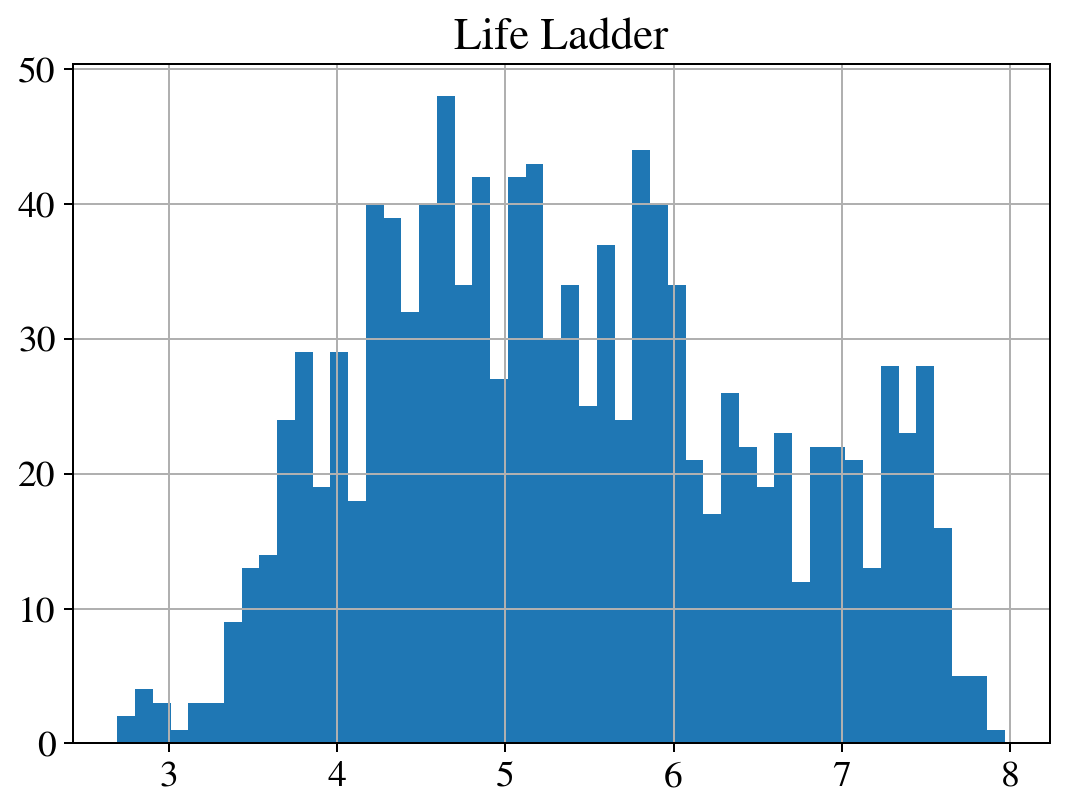

In [16]:
data = dropped.copy()
data['year'] = data['year'] - 2000
_ = data[['Life Ladder']].hist(bins=50)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


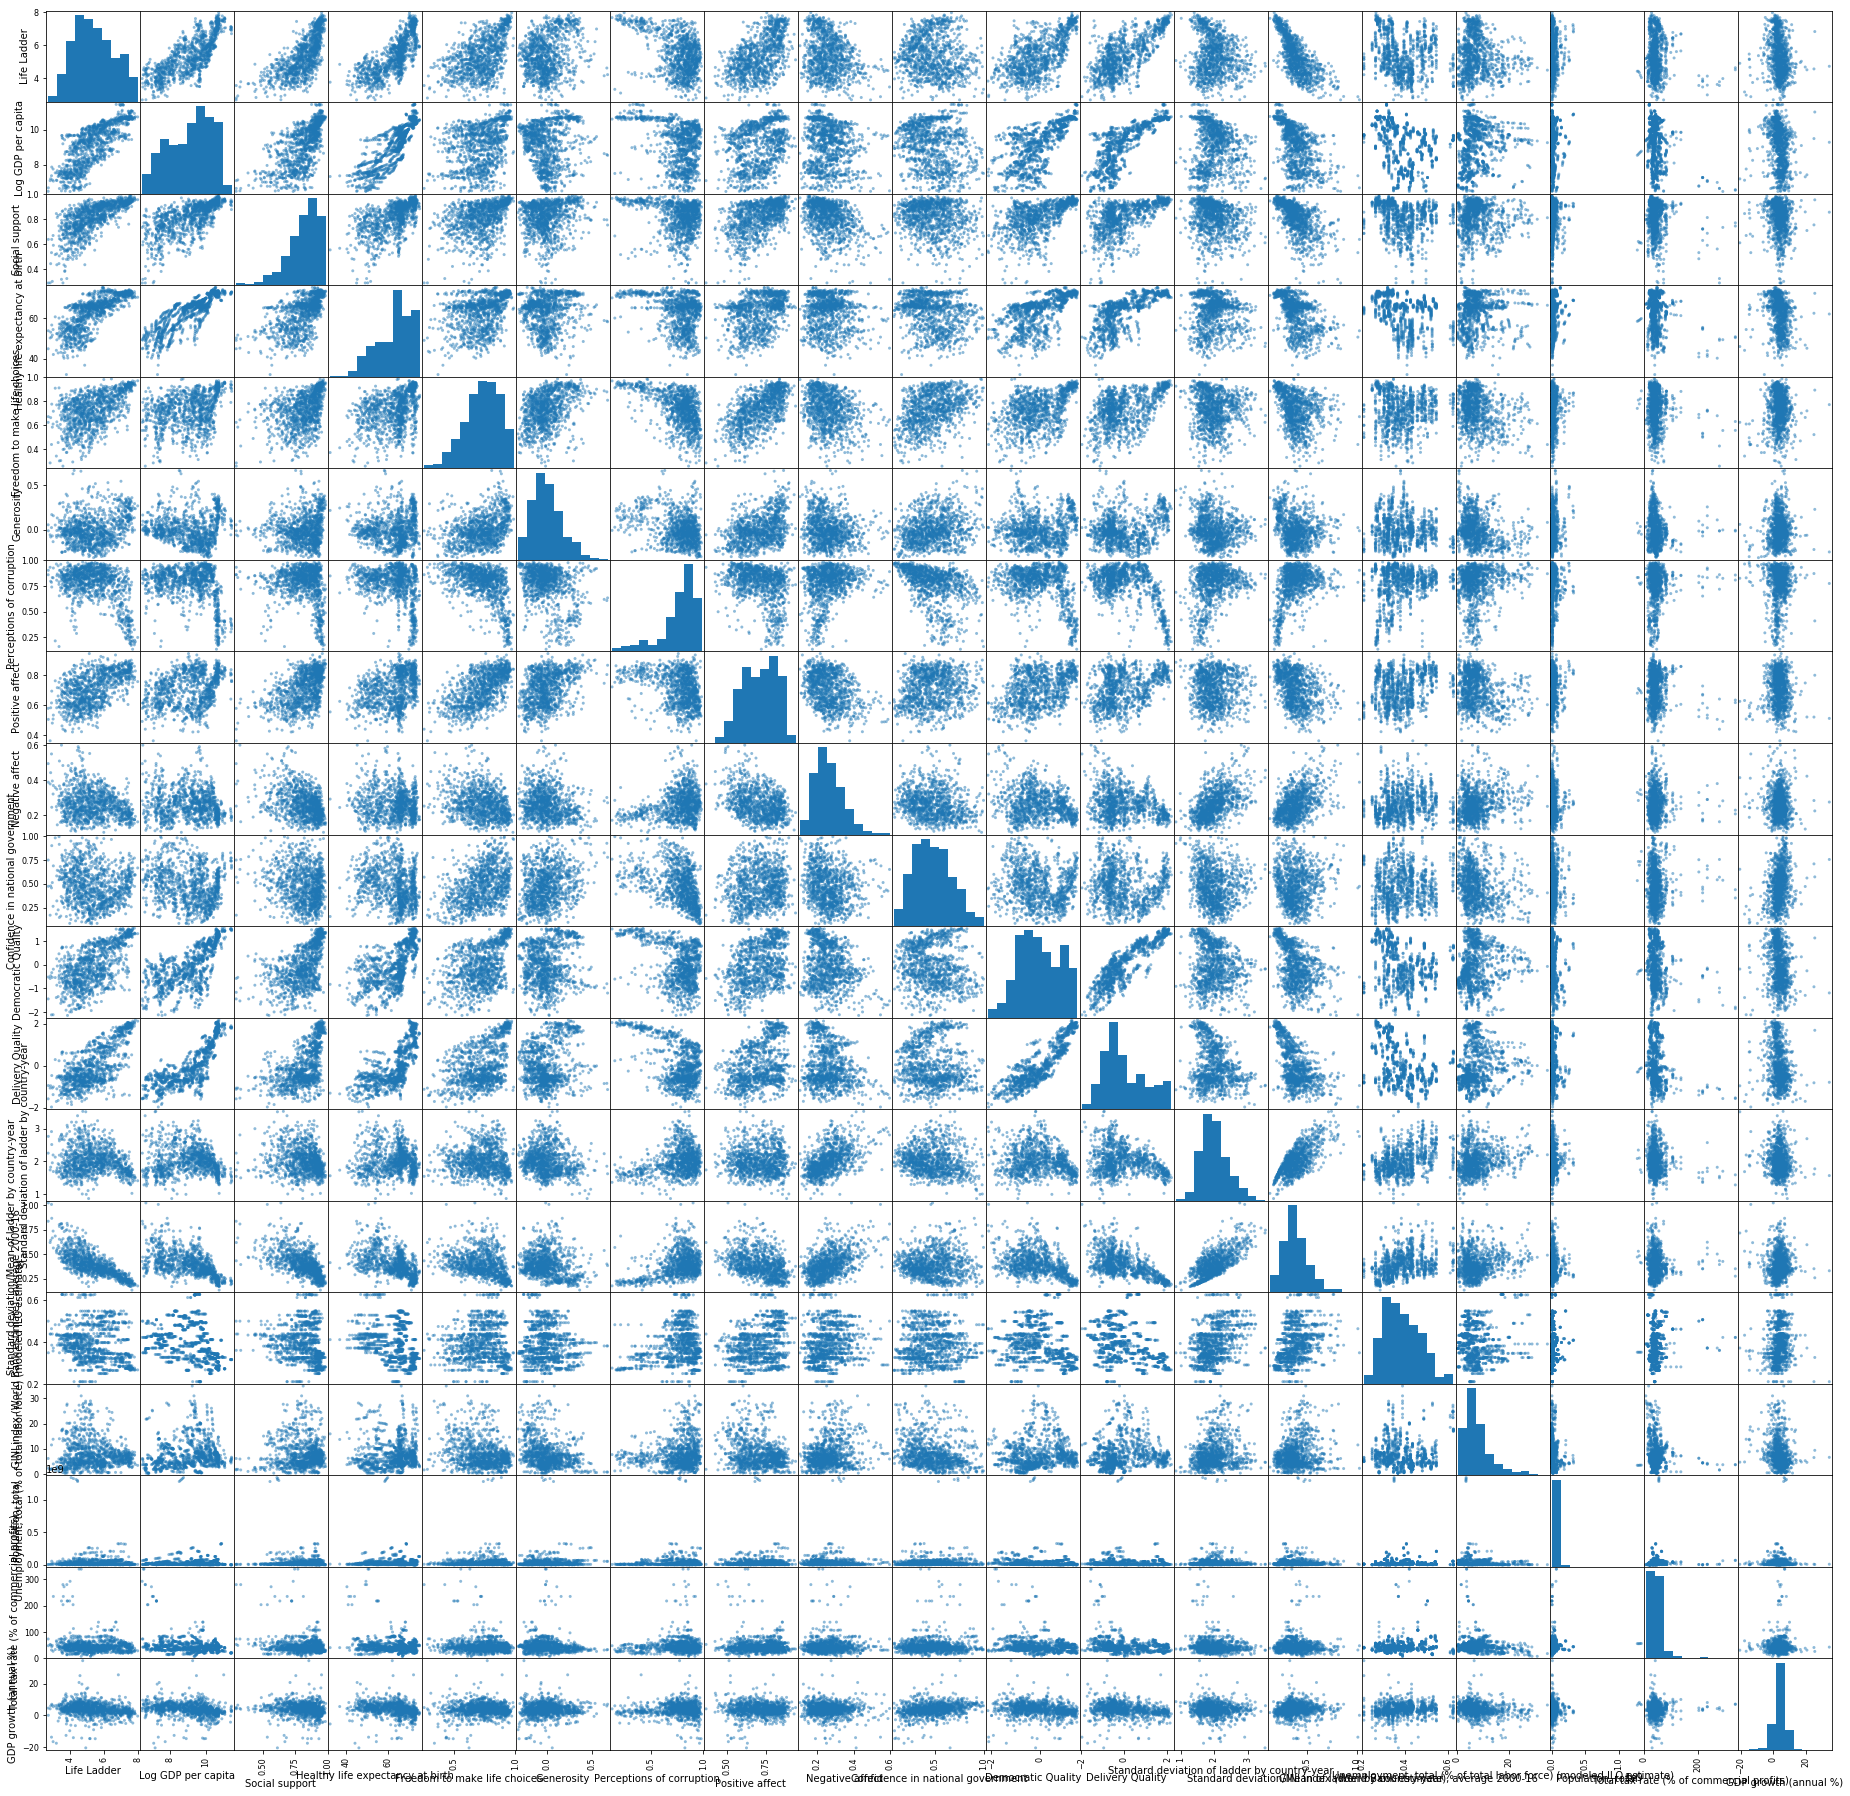

In [18]:
_ = scatter_matrix(data.iloc[:, 2:21], alpha=0.5, figsize=(32, 32))

In [32]:
data.corr()

year  Life Ladder  \
year                                                1.000000     0.027839   
Life Ladder                                         0.027839     1.000000   
Log GDP per capita                                  0.085761     0.782985   
Social support                                     -0.041479     0.713091   
Healthy life expectancy at birth                    0.139147     0.766239   
Freedom to make life choices                        0.168928     0.549379   
Generosity                                         -0.002916     0.251401   
Perceptions of corruption                          -0.085140    -0.464561   
Positive affect                                     0.007931     0.567479   
Negative affect                                     0.208723    -0.243818   
Confidence in national government                   0.006139    -0.099048   
Democratic Quality                                  0.018918     0.641187   
Delivery Quality                                    0.035871     0.729272   
Standard deviation of ladder by country-year        0.285601    -0.164790   
Standard deviation/Mean of ladder by country-year   0.194055    -0.757231   
GINI index (World Bank estimate), average 2000-16  -0.047173    -0.207565   
Unemployment, total (% of total labor force) (m...  0.027177    -0.098167   
Population, total                                   0.116040    -0.022752   
Total tax rate (% of commercial profits)           -0.152077    -0.116525   
GDP growth (annual %)                              -0.128690    -0.179697   

                                                    Log GDP per capita  \
year                                                          0.085761   
Life Ladder                                                   0.782985   
Log GDP per capita                                            1.000000   
Social support                                                0.670213   
Healthy life expectancy at birth                              0.856864   
Freedom to make life choices                                  0.370837   
Generosity                                                    0.025104   
Perceptions of corruption                                    -0.338150   
Positive affect                                               0.326417   
Negative affect                                              -0.125721   
Confidence in national government                            -0.193890   
Democratic Quality                                            0.696758   
Delivery Quality                                              0.798885   
Standard deviation of ladder by country-year                 -0.109923   
Standard deviation/Mean of ladder by country-year            -0.574851   
GINI index (World Bank estimate), average 2000-16            -0.343128   
Unemployment, total (% of total labor force) (m...            0.149280   
Population, total                                             0.005652   
Total tax rate (% of commercial profits)                     -0.226236   
GDP growth (annual %)                                        -0.253228   

                                                    Social support  \
year                                                     -0.041479   
Life Ladder                                               0.713091   
Log GDP per capita                                        0.670213   
Social support                                            1.000000   
Healthy life expectancy at birth                          0.610335   
Freedom to make life choices                              0.412240   
Generosity                                                0.131232   
Perceptions of corruption                                -0.214412   
Positive affect                                           0.495252   
Negative affect                                          -0.378747   
Confidence in national government                        -0.173755   
Democratic Quality                         

In [170]:
name_table = {
    'Life Ladder': 'happiniess', 
    'Log GDP per capita': 'gdp_pc',
    'Social support': 'support',
    'Population, total': 'pop',
    'Total tax rate (% of commercial profits)': 'tax',
    'GDP growth (annual %)': 'gdp_g',
    'Healthy life expectancy at birth': 'life_expected',
    'Freedom to make life choices': 'choice',
    'Generosity': 'generosity',
    'Perceptions of corruption': 'corruption',
    'Positive affect': 'positive',
    'Negative affect': 'negative',
    'Confidence in national government': 'gov_confidence',
    'Democratic Quality': 'democoratic',
    'Delivery Quality': 'delivery',
    'Standard deviation of ladder by country-year': 'sd_country_year',
    'Standard deviation/Mean of ladder by country-year': 'sd_m_country_year',
    'GINI index (World Bank estimate), average 2000-16': 'gini',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'unemployment'
}
data = data.rename(columns=name_table)
data

country  year  happiniess    gdp_pc   support  life_expected  \
11      Albania     7    4.634252  9.077331  0.821372      65.800003   
15      Albania    12    5.510124  9.246655  0.784502      66.959999   
16      Albania    13    4.550648  9.258445  0.759477      67.239998   
17      Albania    14    4.813763  9.278104  0.625587      67.519997   
18      Albania    15    4.606651  9.302960  0.639356      67.800003   
19      Albania    16    4.511101  9.337532  0.638411      68.099998   
20      Albania    17    4.639548  9.376145  0.637698      68.400002   
29       Angola    11    5.589001  8.684613  0.723094      52.500000   
30       Angola    12    4.360250  8.699498  0.752593      53.200001   
31       Angola    13    3.937107  8.730368  0.721591      53.900002   
32       Angola    14    3.794838  8.741481  0.754615      54.599998   
33    Argentina     6    6.312925  9.716692  0.938463      66.820000   
34    Argentina     7    6.073158  9.792596  0.862206      66.940002   
35    Argentina     8    5.961034  9.822107  0.892195      67.059998   
36    Argentina     9    6.424133  9.750825  0.918693      67.180000   
37    Argentina    10    6.441067  9.836924  0.926799      67.300003   
38    Argentina    11    6.775805  9.884781  0.889073      67.480003   
39    Argentina    12    6.468387  9.863960  0.901776      67.660004   
40    Argentina    13    6.582260  9.877256  0.909874      67.839996   
41    Argentina    14    6.671114  9.841482  0.917870      68.019997   
42    Argentina    15    6.697131  9.858329  0.926492      68.199997   
43    Argentina    16    6.427221  9.830088  0.882819      68.400002   
44    Argentina    17    6.039330  9.848709  0.906699      68.599998   
46      Armenia     6    4.289311  8.717719  0.681877      64.800003   
47      Armenia     7    4.881516  8.855183  0.759644      64.900002   
48      Armenia     8    4.651972  8.930409  0.709486      65.000000   
49      Armenia     9    4.177582  8.784616  0.680007      65.099998   
50      Armenia    10    4.367811  8.810287  0.660342      65.199997   
51      Armenia    11    4.260491  8.856818  0.705108      65.360001   
52      Armenia    12    4.319712  8.924142  0.676446      65.519997   
...         ...   ...         ...       ...       ...            ...   
1669      Yemen     9    4.809259  8.360027  0.756430      54.000000   
1670      Yemen    10    4.350313  8.407098  0.726612      54.299999   
1671      Yemen    11    3.746256  8.244134  0.662680      54.299999   
1672      Yemen    12    4.060601  8.241021  0.681678      54.299999   
1673      Yemen    13    4.217679  8.261729  0.693905      54.299999   
1674      Yemen    14    3.967958  8.233982  0.638252      54.299999   
1675      Yemen    15    2.982674  7.744412  0.668683      54.299999   
1679     Zambia     6    4.824455  7.866006  0.797665      44.259998   
1680     Zambia     7    3.998293  7.918941  0.687989      45.720001   
1681     Zambia     8    4.730263  7.966175  0.624418      47.180000   
1682     Zambia     9    5.260361  8.026193  0.781926      48.639999   
1683     Zambia    11    4.999114  8.120028  0.864023      50.840000   
1684     Zambia    12    5.013375  8.163204  0.780023      51.580002   
1685     Zambia    13    5.243996  8.182191  0.761312      52.320000   
1686     Zambia    14    4.345837  8.197678  0.706223      53.060001   
1687     Zambia    15    4.843164  8.196217  0.691483      53.799999   
1688     Zambia    16    4.347544  8.203072  0.767047      54.299999   
1689     Zambia    17    3.932777  8.213179  0.743754      54.799999   
1691   Zimbabwe     6    3.826268  7.366704  0.821656      41.580002   
1692   Zimbabwe     7    3.280247  7.313939  0.828113      42.860001   
1693   Zimbabwe     8    3.174264  7.102516  0.843475      44.139999   
1694   Zimbabwe     9    4.055914  7.197595  0.805781      45.419998   
1695   Zimbabwe    10    4.681570  7.296330  0.856638      46.700001   
1696   Zimbabwe    11    4.845642  7.418864  0.8

In [223]:
fs1 = ['year', 'gdp_pc', 'support', 'pop', 'tax', 'gdp_g', 'life_expected', 'choice', 'generosity', 'corruption', 'positive', 'negative', 'gov_confidence', 'democoratic', 'delivery', 'sd_country_year', 'sd_m_country_year', 'gini', 'unemployment']

#fs2 = [s[0] + ' + ' + s[1] for s in set([(x, y) if x > y else (y, x)  for x in fs1 for y in [z for z in fs1 if z != x] ])]


#fs = fs1 + fs2
print(fs1)

['year', 'gdp_pc', 'support', 'pop', 'tax', 'gdp_g', 'life_expected', 'choice', 'generosity', 'corruption', 'positive', 'negative', 'gov_confidence', 'democoratic', 'delivery', 'sd_country_year', 'sd_m_country_year', 'gini', 'unemployment']


                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.17
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           0.000858
Time:                        18:26:08   Log-Likelihood:                -1801.7
No. Observations:                1150   AIC:                             3607.
Df Residuals:                    1148   BIC:                             3617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.5646      0.060     93.370   

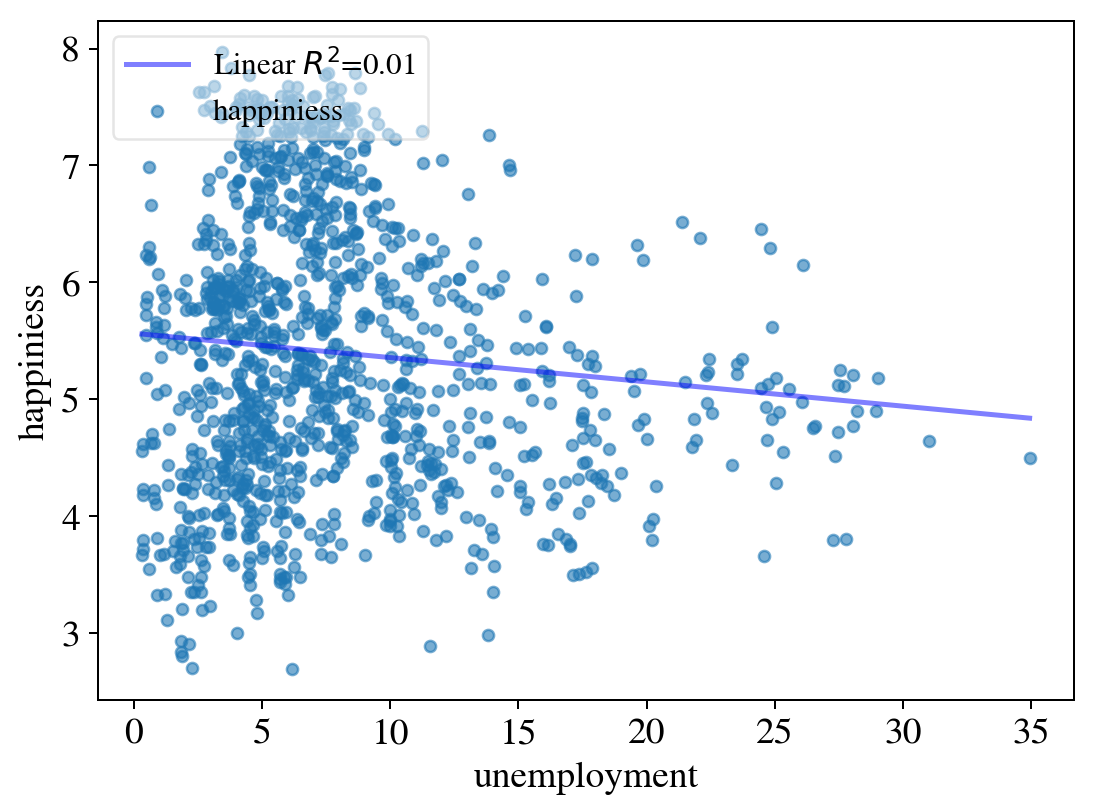






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     51.69
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           1.17e-12
Time:                        18:26:09   Log-Likelihood:                -1781.9
No. Observations:                1150   AIC:                             3568.
Df Residuals:                    1148   BIC:                             3578.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5126      0.158     41.177    

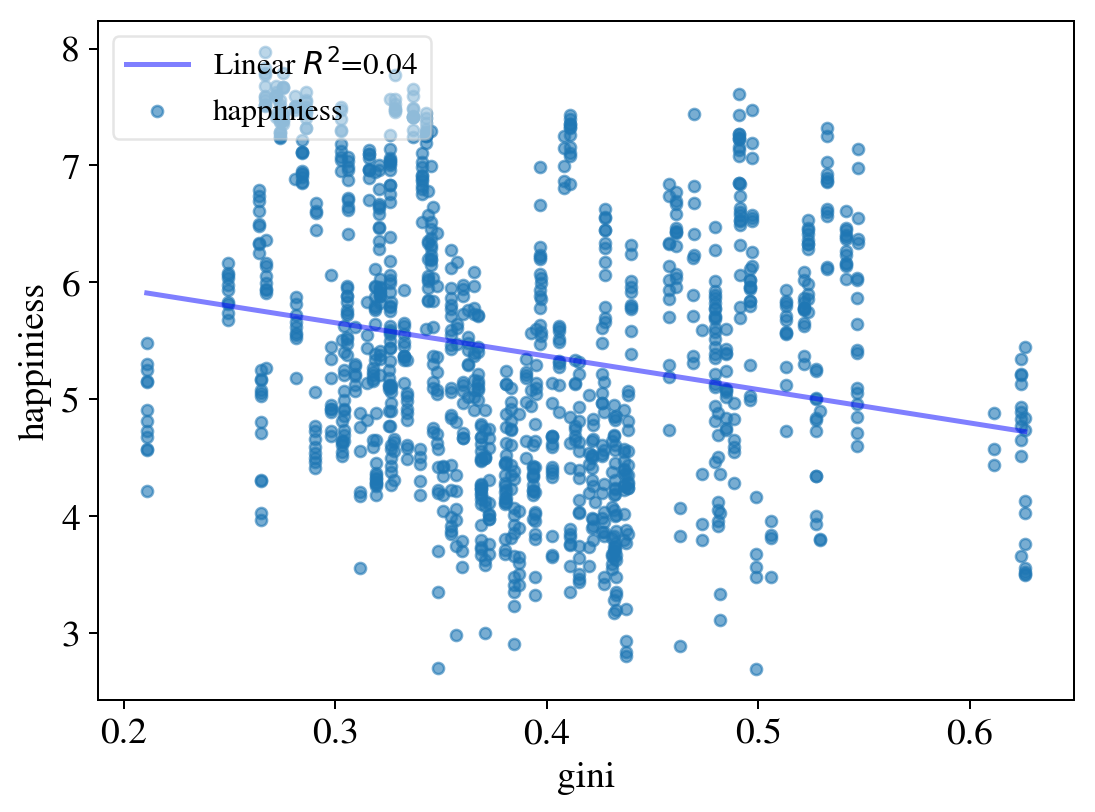






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1543.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):          1.33e-214
Time:                        18:26:09   Log-Likelihood:                -1317.4
No. Observations:                1150   AIC:                             2639.
Df Residuals:                    1148   BIC:                             2649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.1831     

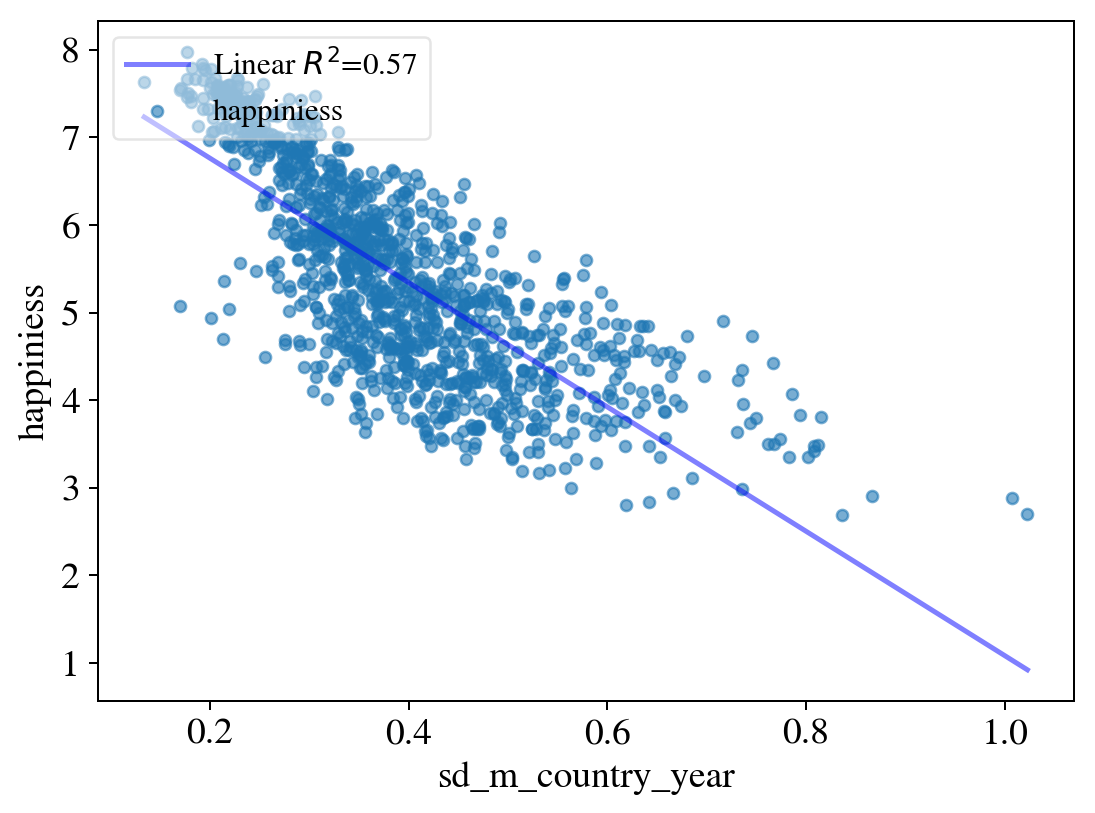






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     32.04
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           1.90e-08
Time:                        18:26:09   Log-Likelihood:                -1791.4
No. Observations:                1150   AIC:                             3587.
Df Residuals:                    1148   BIC:                             3597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.3766      0.176

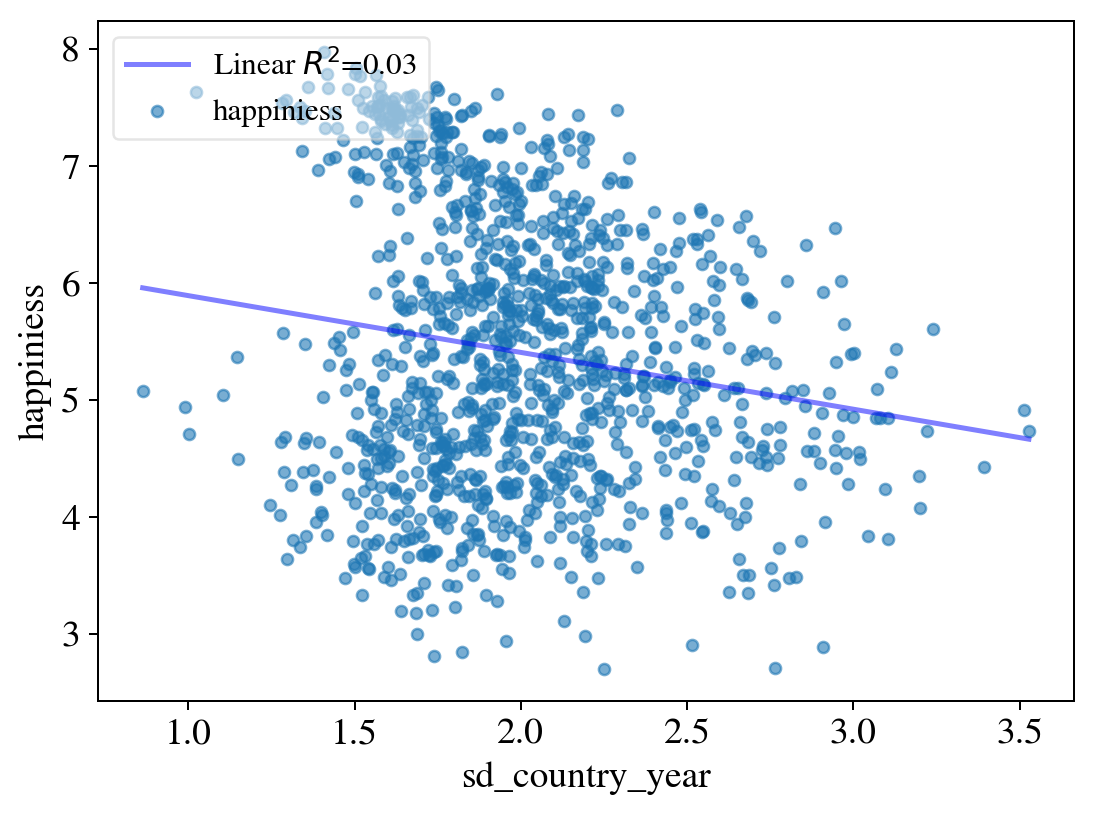






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1304.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):          2.07e-191
Time:                        18:26:10   Log-Likelihood:                -1370.8
No. Observations:                1150   AIC:                             2746.
Df Residuals:                    1148   BIC:                             2756.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3911      0.024    229.171    

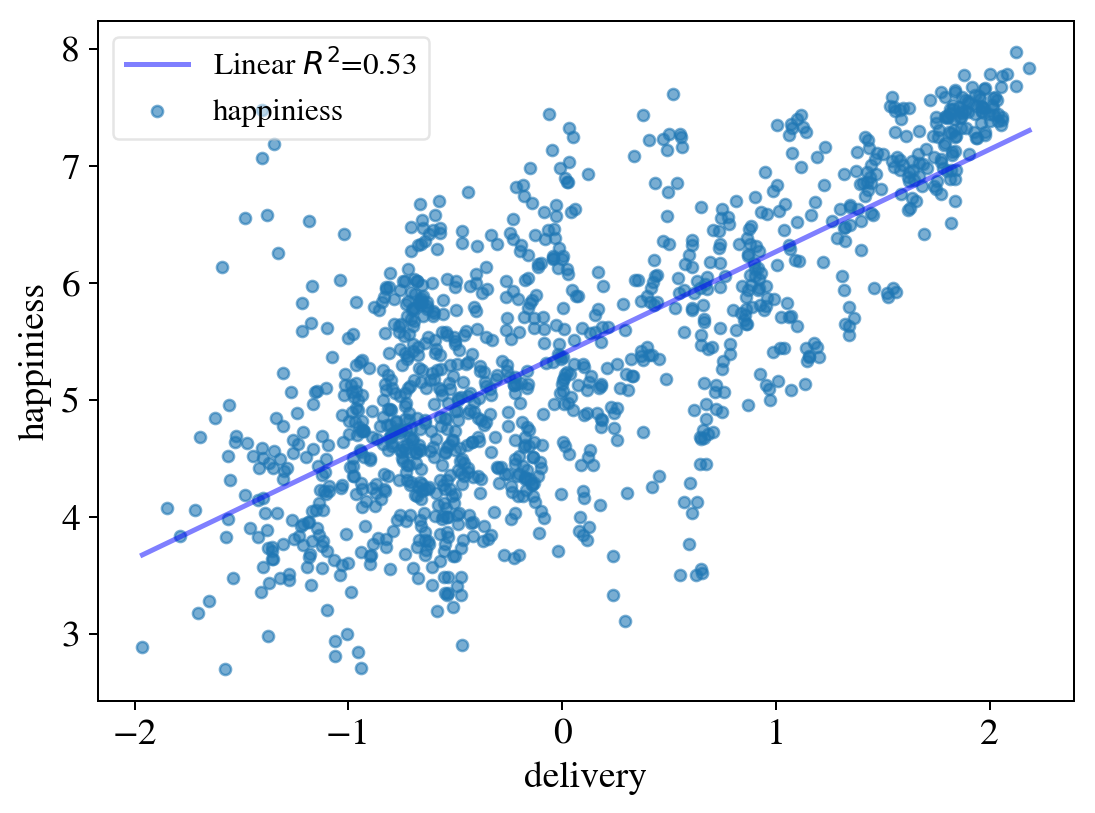






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     801.5
Date:                Sat, 13 Apr 2019   Prob (F-statistic):          3.63e-134
Time:                        18:26:10   Log-Likelihood:                -1502.7
No. Observations:                1150   AIC:                             3009.
Df Residuals:                    1148   BIC:                             3020.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.4355      0.026    205.823 

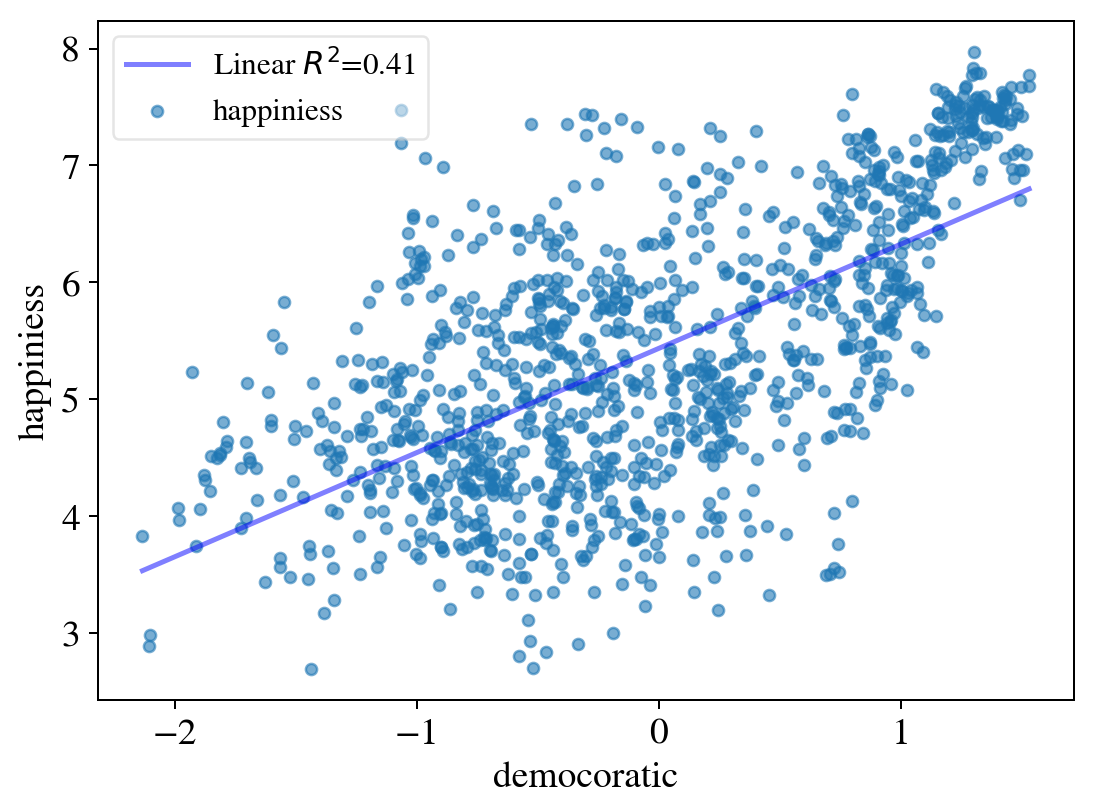






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.37
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           0.000770
Time:                        18:26:10   Log-Likelihood:                -1801.6
No. Observations:                1150   AIC:                             3607.
Df Residuals:                    1148   BIC:                             3617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.6904      0.092   

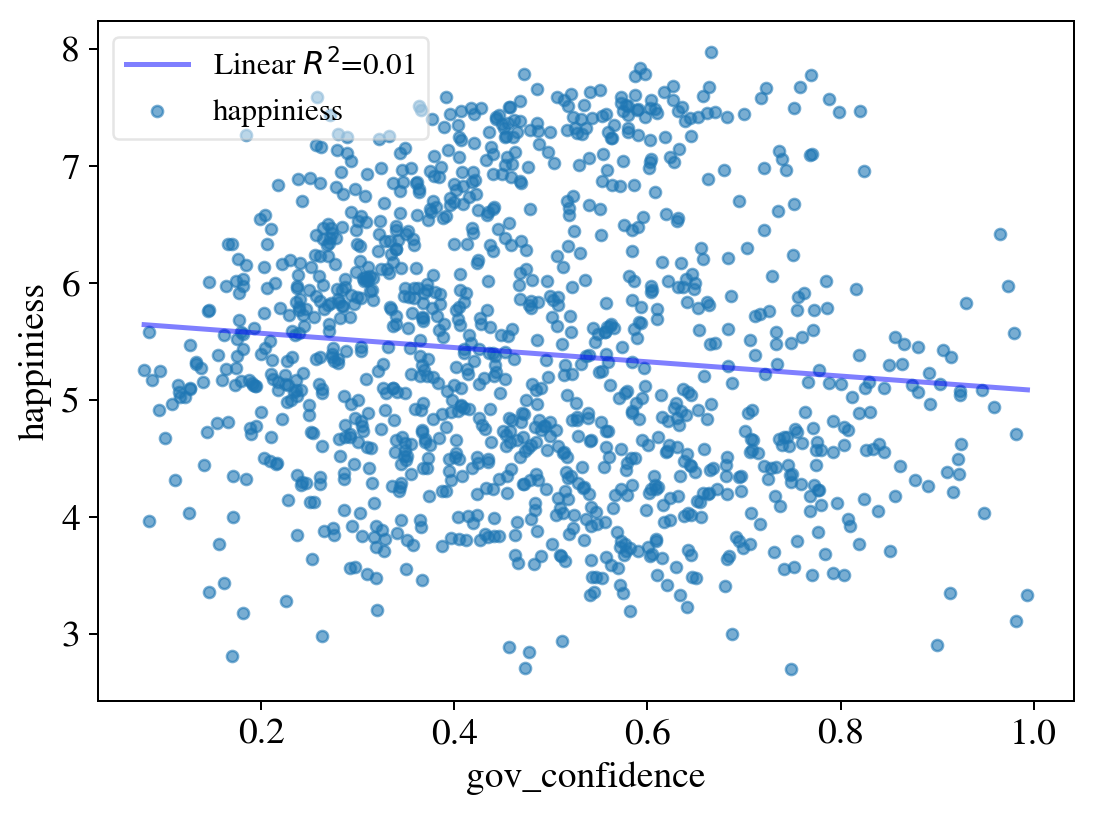






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     72.56
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           5.02e-17
Time:                        18:26:10   Log-Likelihood:                -1772.0
No. Observations:                1150   AIC:                             3548.
Df Residuals:                    1148   BIC:                             3558.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3395      0.115     55.101    

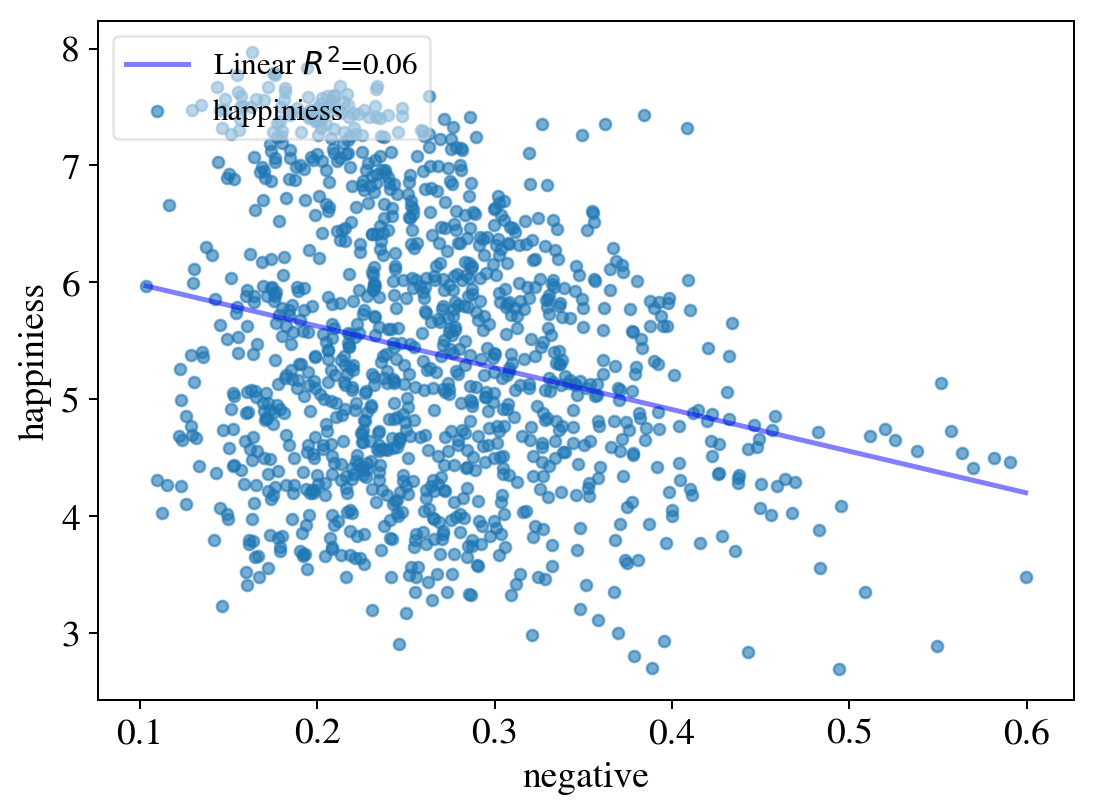






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     545.3
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           5.38e-99
Time:                        18:26:11   Log-Likelihood:                -1583.7
No. Observations:                1150   AIC:                             3171.
Df Residuals:                    1148   BIC:                             3182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0652      0.188      5.671    

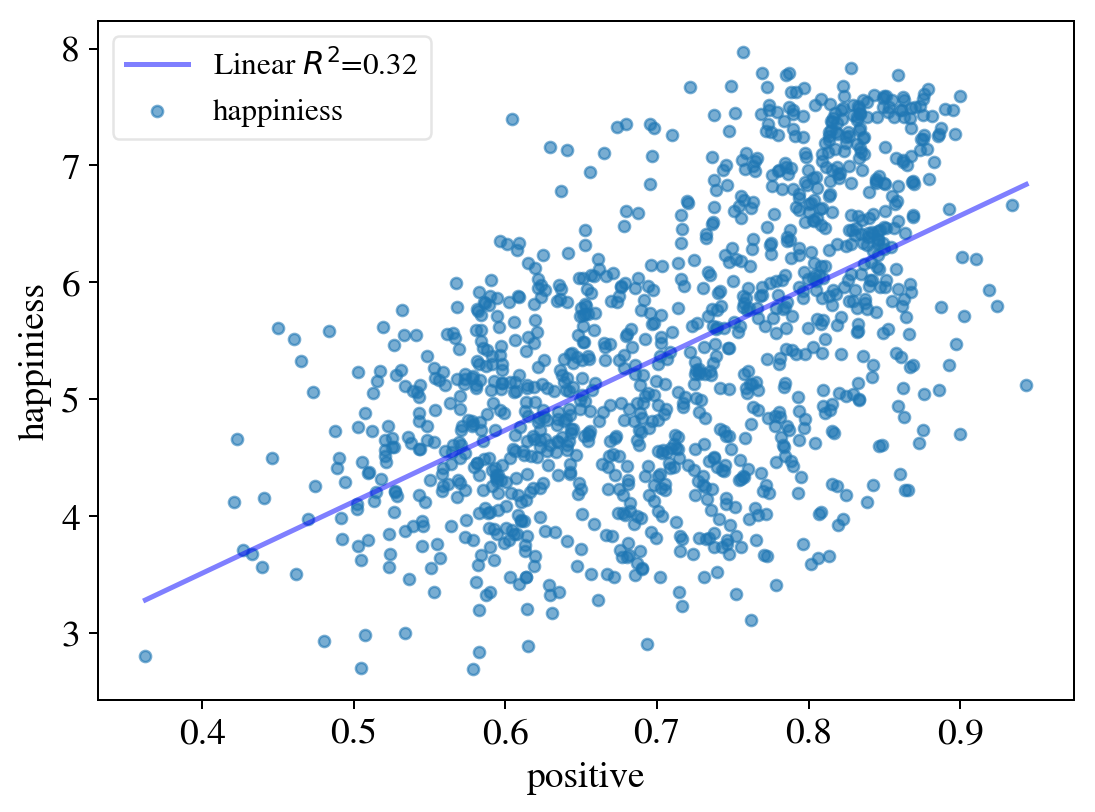






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     315.9
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           1.26e-62
Time:                        18:26:11   Log-Likelihood:                -1667.4
No. Observations:                1150   AIC:                             3339.
Df Residuals:                    1148   BIC:                             3349.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8387      0.140     55.811    

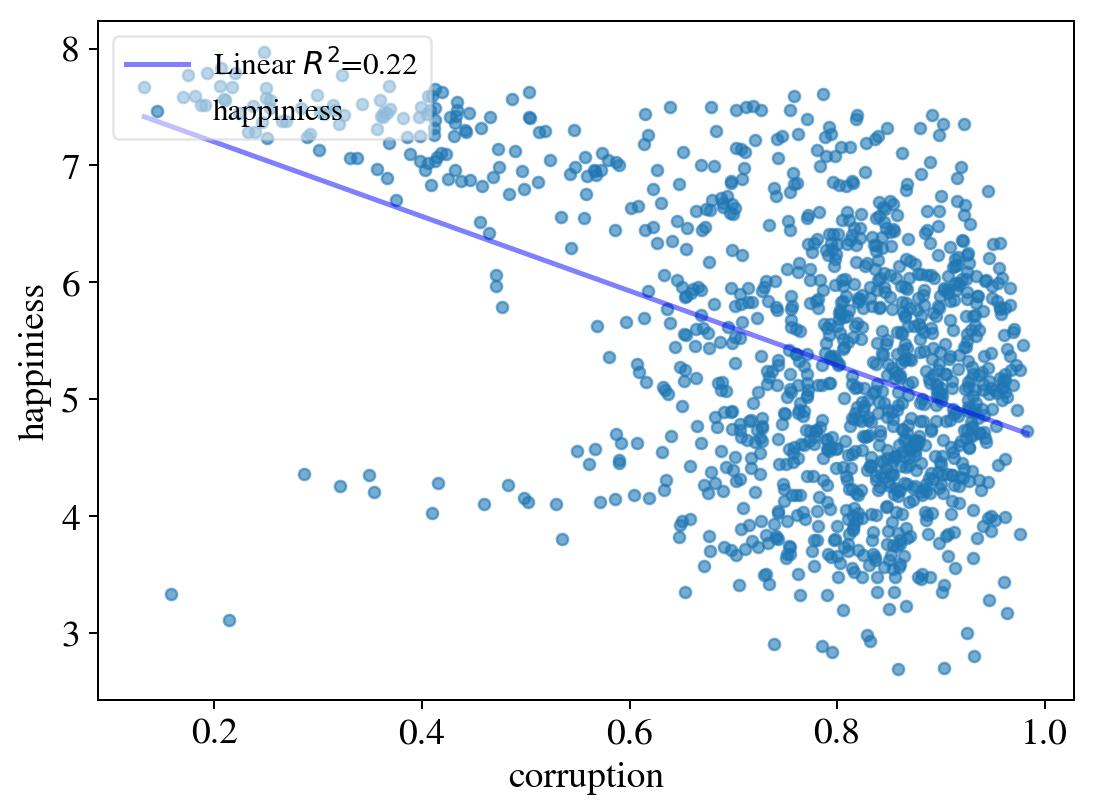






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     77.45
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           4.91e-18
Time:                        18:26:11   Log-Likelihood:                -1769.7
No. Observations:                1150   AIC:                             3543.
Df Residuals:                    1148   BIC:                             3553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4002      0.033    162.293    

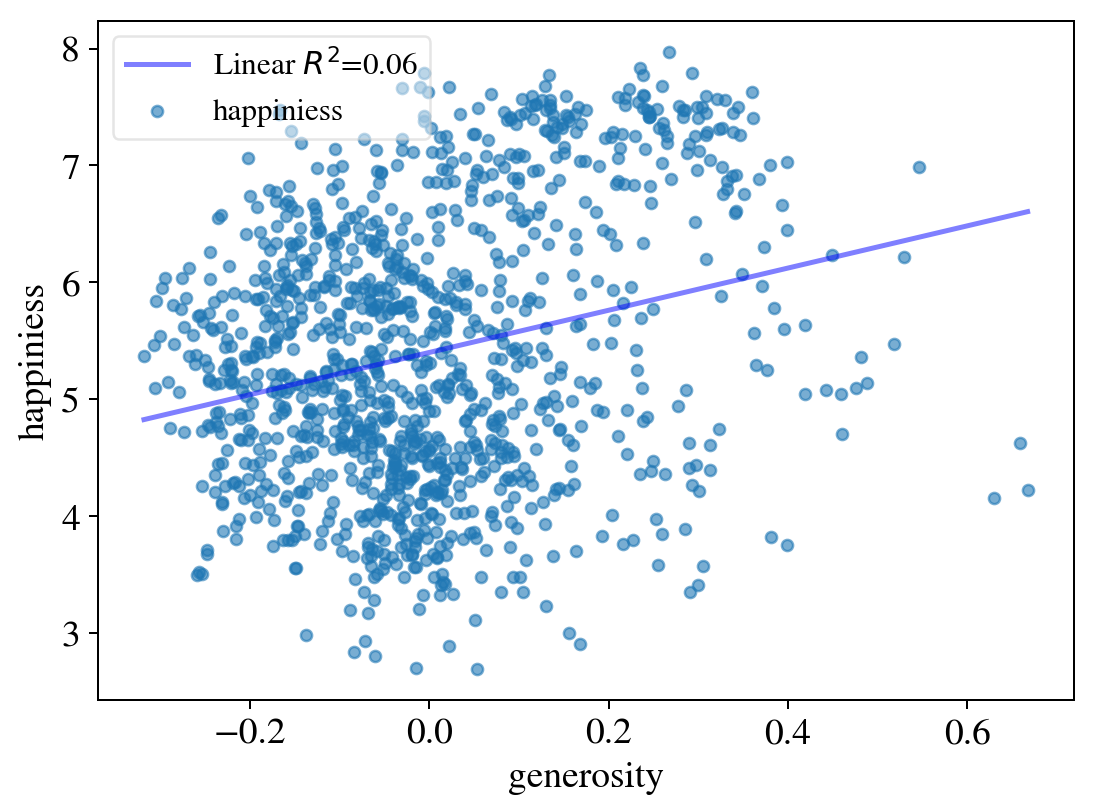






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     496.3
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           1.17e-91
Time:                        18:26:12   Log-Likelihood:                -1600.6
No. Observations:                1150   AIC:                             3205.
Df Residuals:                    1148   BIC:                             3215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0789      0.152     13.686    

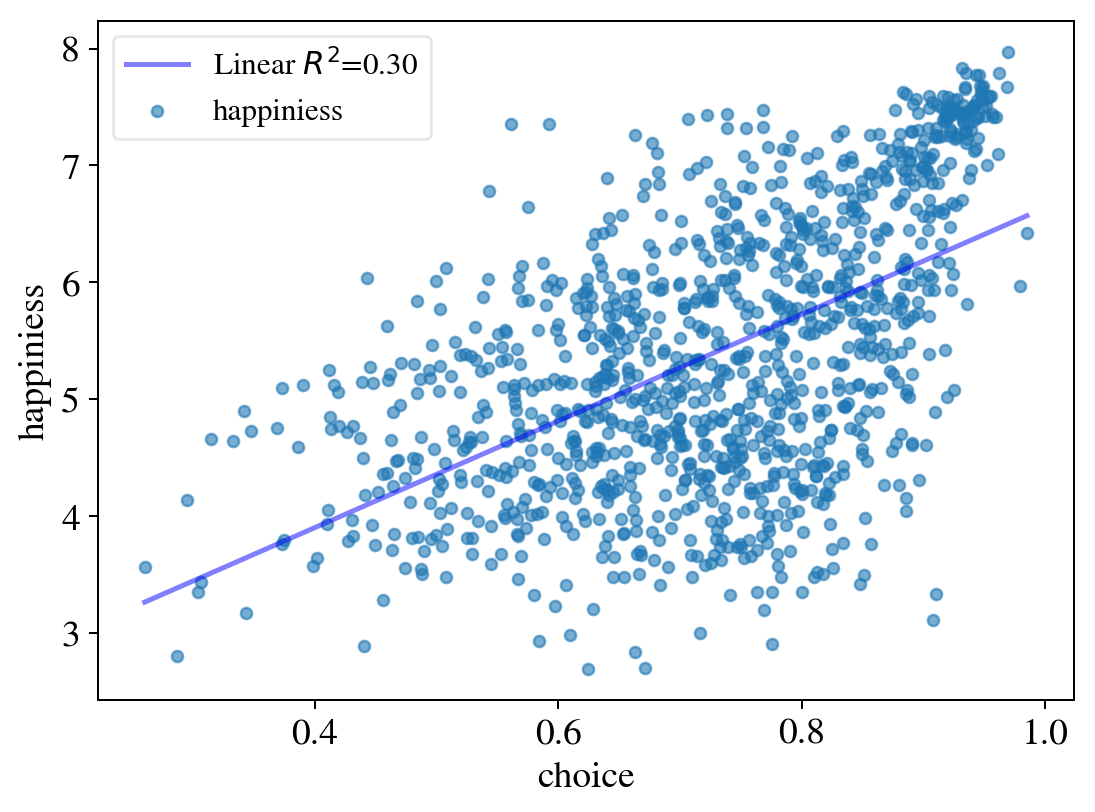






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1632.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):          9.30e-223
Time:                        18:26:12   Log-Likelihood:                -1298.6
No. Observations:                1150   AIC:                             2601.
Df Residuals:                    1148   BIC:                             2611.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5380      0.173     -

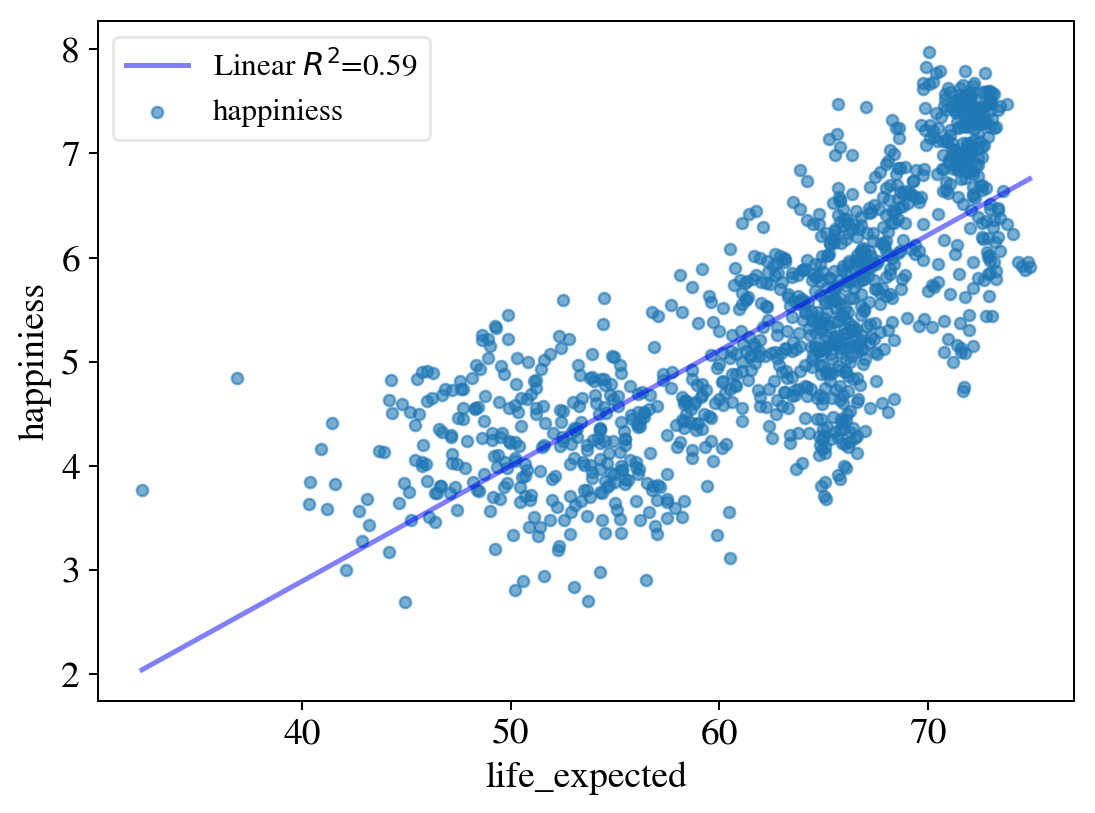






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     38.31
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           8.40e-10
Time:                        18:26:12   Log-Likelihood:                -1788.3
No. Observations:                1150   AIC:                             3581.
Df Residuals:                    1148   BIC:                             3591.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5894      0.045    122.994    

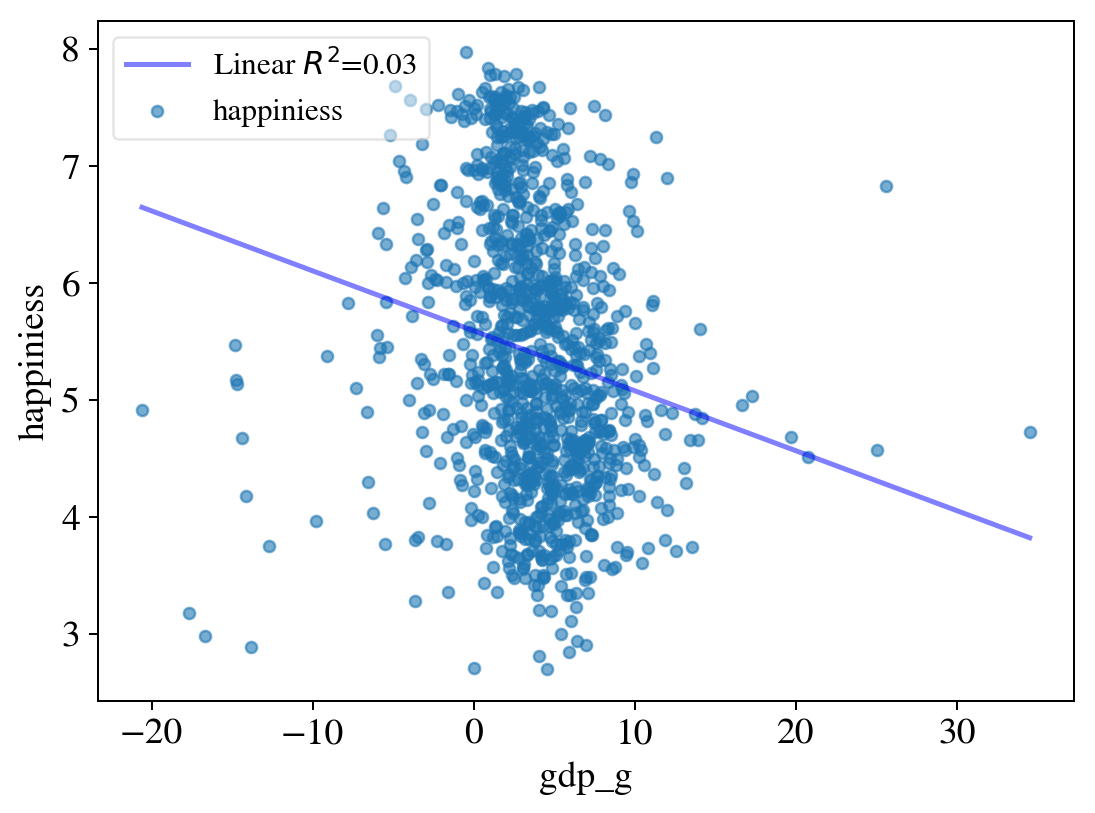






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     15.80
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           7.47e-05
Time:                        18:26:13   Log-Likelihood:                -1799.4
No. Observations:                1150   AIC:                             3603.
Df Residuals:                    1148   BIC:                             3613.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6137      0.063     88.608    

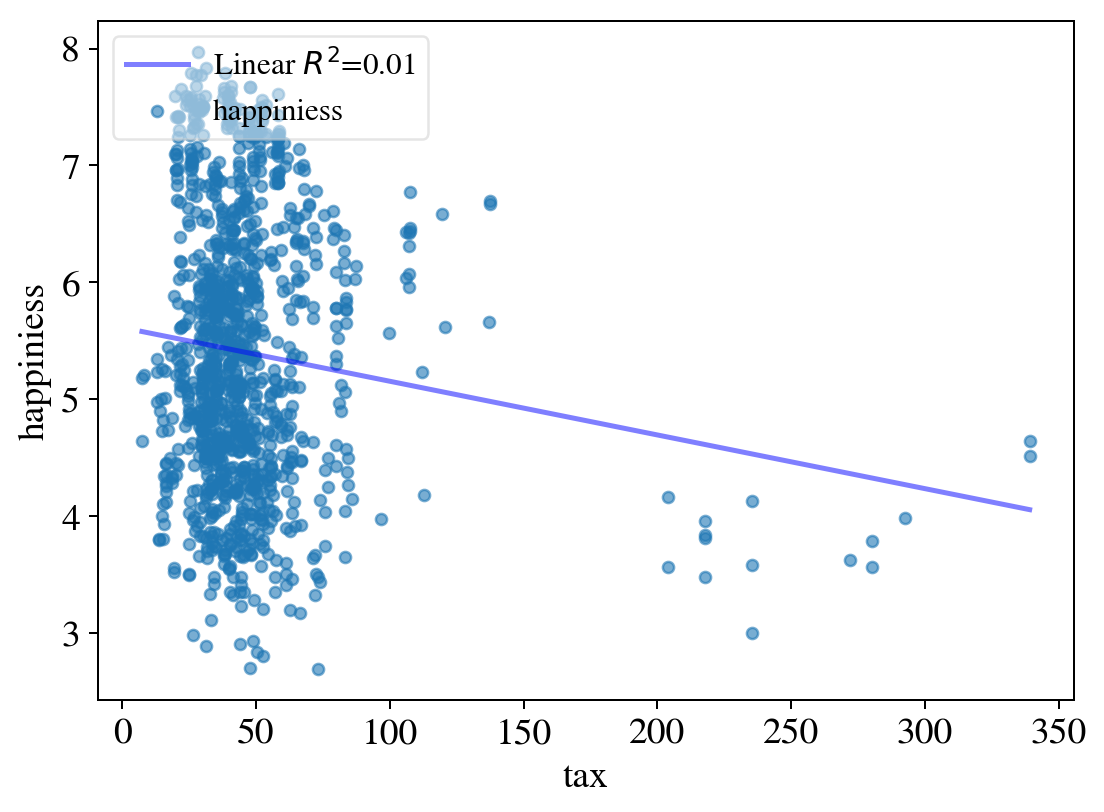






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5946
Date:                Sat, 13 Apr 2019   Prob (F-statistic):              0.441
Time:                        18:26:13   Log-Likelihood:                -1806.9
No. Observations:                1150   AIC:                             3618.
Df Residuals:                    1148   BIC:                             3628.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4106      0.036    149.006    

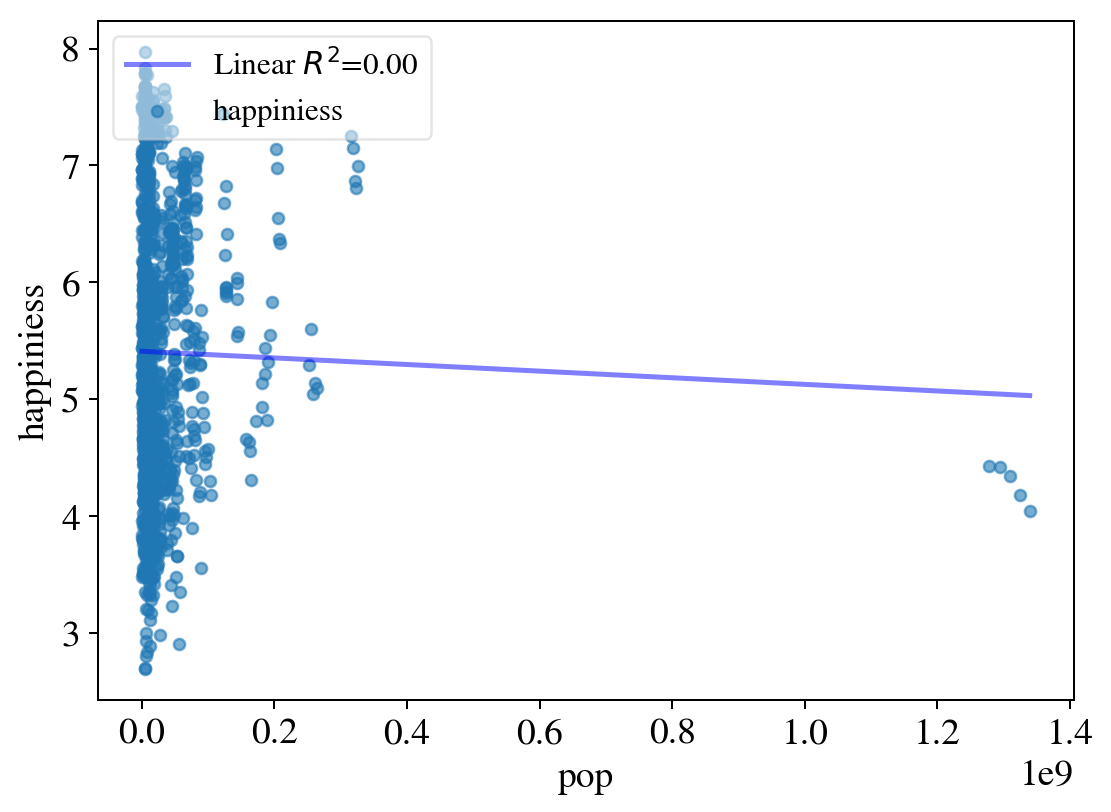






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     1188.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):          2.84e-179
Time:                        18:26:13   Log-Likelihood:                -1398.8
No. Observations:                1150   AIC:                             2802.
Df Residuals:                    1148   BIC:                             2812.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2186      0.165     -1.326    

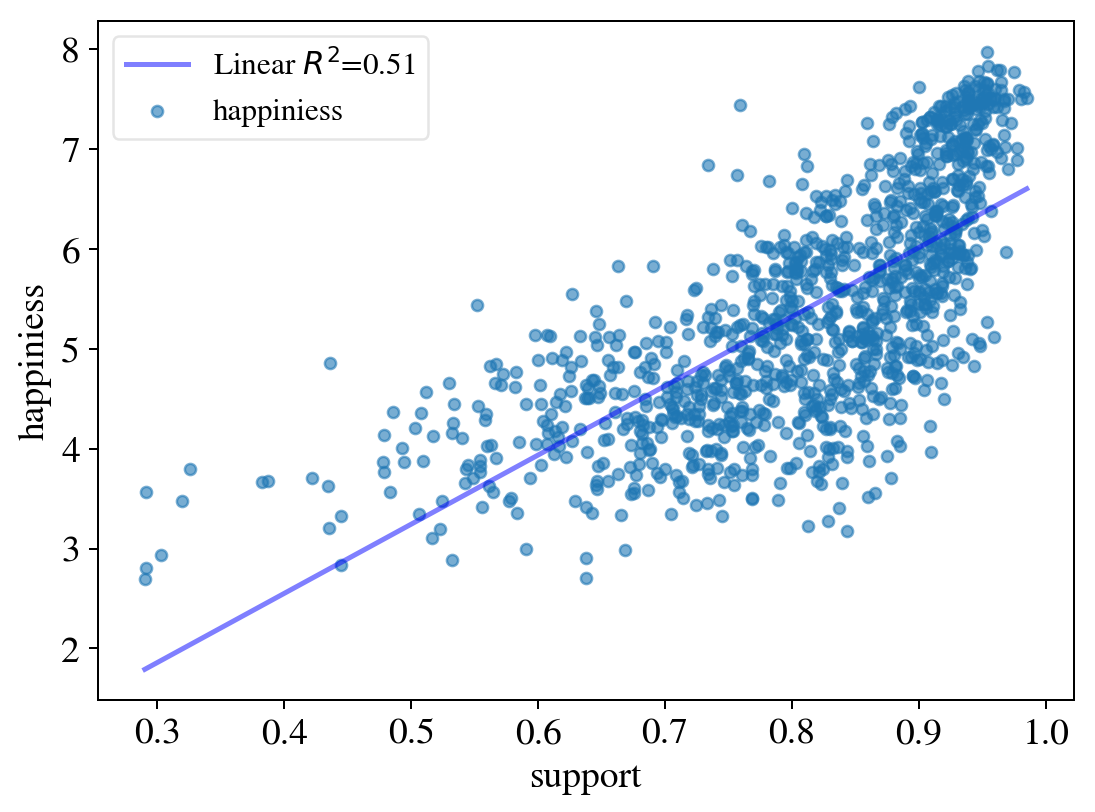






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     1819.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):          6.05e-239
Time:                        18:26:14   Log-Likelihood:                -1261.3
No. Observations:                1150   AIC:                             2527.
Df Residuals:                    1148   BIC:                             2537.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5399      0.164     -9.381    

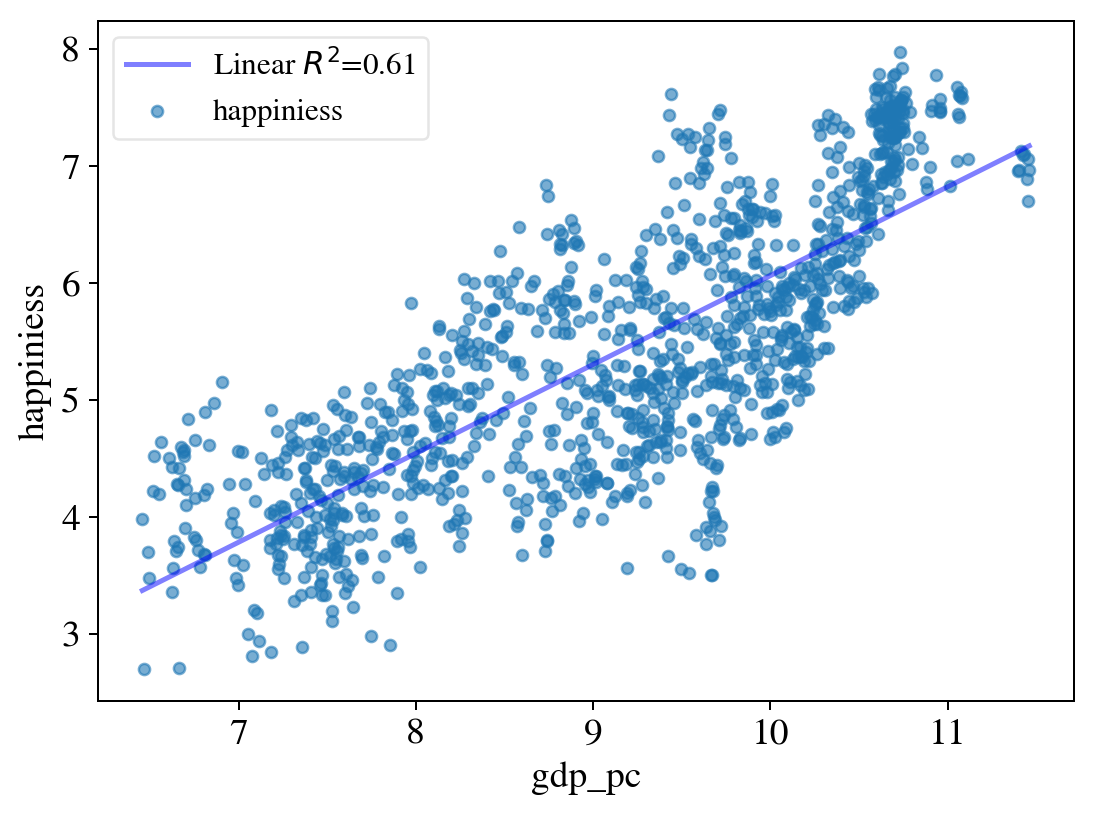






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8904
Date:                Sat, 13 Apr 2019   Prob (F-statistic):              0.346
Time:                        18:26:14   Log-Likelihood:                -1806.8
No. Observations:                1150   AIC:                             3618.
Df Residuals:                    1148   BIC:                             3628.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2846      0.129     41.092    

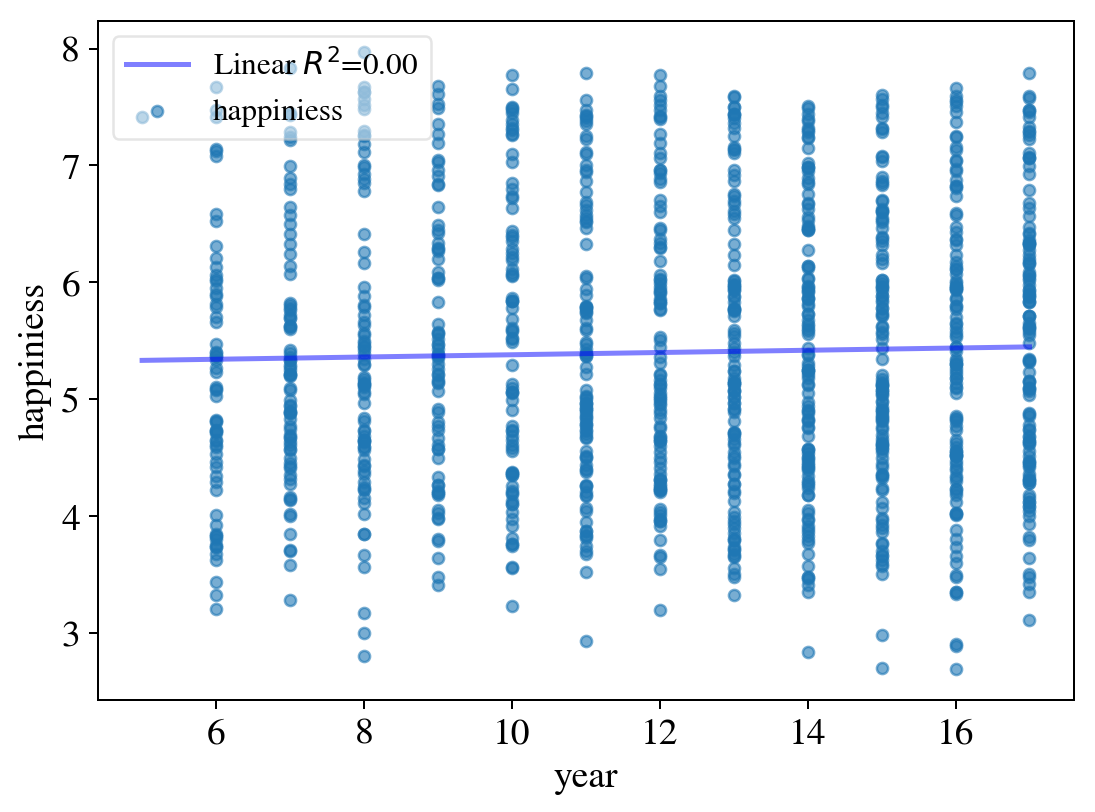

In [172]:
for feature in fs1[::-1]:
    formula =  'happiniess ~ 1 + ' + feature
    mod = smf.ols(formula=formula, data=data).fit()
    print(mod.summary())
    
    x = pd.DataFrame({feature: np.linspace(data[feature].min(), data[feature].max(), len(data[feature]))})
    plt.scatter( data[feature],  data['happiniess'], s=20, alpha=0.6)
    plt.xlabel(feature); plt.ylabel('happiniess')
    plt.plot(x[feature], mod.predict(x), 'b-', label='Linear $R^2$=%.2f' % mod.rsquared, alpha=0.5)
    plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
    plt.show()    
    print('\n\n\n\n')

In [183]:
fs2 = [s[0] + ' + ' + s[1] for s in set([(x, y) if x > y else (y, x)  for x in fs1 for y in [z for z in fs1 if z != x] ])]
for feature in fs2[::-1]:
    formula =  'happiniess ~ 1 + ' + feature
    mod = smf.ols(formula=formula, data=data).fit()
    print(formula)
    print('rsq = ' + str(mod.rsquared))
    print('aic = ' + str(mod.aic))
    print('\n\n\n')

happiniess ~ 1 + positive + delivery
rsq = 0.6312060717740995
aic = 2473.293954061638




happiniess ~ 1 + life_expected + gov_confidence
rsq = 0.5918023715585736
aic = 2590.0343785654904




happiniess ~ 1 + sd_country_year + negative
rsq = 0.06135462719244433
aic = 3547.62362652104




happiniess ~ 1 + life_expected + gini
rsq = 0.5906661744478213
aic = 2593.230897824145




happiniess ~ 1 + unemployment + generosity
rsq = 0.06384627210300775
aic = 3544.5668794454587




happiniess ~ 1 + tax + positive
rsq = 0.3276032124050783
aic = 3163.996139520188




happiniess ~ 1 + sd_m_country_year + pop
rsq = 0.5736722738659563
aic = 2640.009836694921




happiniess ~ 1 + tax + gdp_g
rsq = 0.04491365402415992
aic = 3567.5922355999155




happiniess ~ 1 + tax + corruption
rsq = 0.22267549657491292
aic = 3330.756806351494




happiniess ~ 1 + negative + democoratic
rsq = 0.4212742213537922
aic = 2991.4732882971693




happiniess ~ 1 + gdp_g + corruption
rsq = 0.241823321557337
aic = 3302.074131

rsq = 0.41112072934469834
aic = 3011.4745895220526




happiniess ~ 1 + support + democoratic
rsq = 0.5982525808803323
aic = 2571.7173394945708




happiniess ~ 1 + sd_m_country_year + corruption
rsq = 0.6084475770094466
aic = 2542.157542704707




happiniess ~ 1 + tax + support
rsq = 0.508851065171879
aic = 2802.77974501424




happiniess ~ 1 + sd_m_country_year + gini
rsq = 0.5774558383558445
aic = 2629.7582827446945




happiniess ~ 1 + corruption + choice
rsq = 0.34524026004195996
aic = 3133.4288349056756




happiniess ~ 1 + negative + life_expected
rsq = 0.6172867244478923
aic = 2515.899215088041




happiniess ~ 1 + unemployment + democoratic
rsq = 0.43482581287248867
aic = 2964.224298266815




happiniess ~ 1 + year + unemployment
rsq = 0.010568123690269049
aic = 3608.220775424979




happiniess ~ 1 + sd_m_country_year + gov_confidence
rsq = 0.580199552646158
aic = 2622.2666158926068




happiniess ~ 1 + support + gov_confidence
rsq = 0.5091361790387515
aic = 2802.111971700332


In [209]:
import itertools

all = []

for r in range(2, len(fs1)):
    all = all + [t for t in itertools.combinations(fs1, r)]

len(all)

all

[('year', 'gdp_pc'),
 ('year', 'support'),
 ('year', 'pop'),
 ('year', 'tax'),
 ('year', 'gdp_g'),
 ('year', 'life_expected'),
 ('year', 'choice'),
 ('year', 'generosity'),
 ('year', 'corruption'),
 ('year', 'positive'),
 ('year', 'negative'),
 ('year', 'gov_confidence'),
 ('year', 'democoratic'),
 ('year', 'delivery'),
 ('year', 'sd_country_year'),
 ('year', 'sd_m_country_year'),
 ('year', 'gini'),
 ('year', 'unemployment'),
 ('gdp_pc', 'support'),
 ('gdp_pc', 'pop'),
 ('gdp_pc', 'tax'),
 ('gdp_pc', 'gdp_g'),
 ('gdp_pc', 'life_expected'),
 ('gdp_pc', 'choice'),
 ('gdp_pc', 'generosity'),
 ('gdp_pc', 'corruption'),
 ('gdp_pc', 'positive'),
 ('gdp_pc', 'negative'),
 ('gdp_pc', 'gov_confidence'),
 ('gdp_pc', 'democoratic'),
 ('gdp_pc', 'delivery'),
 ('gdp_pc', 'sd_country_year'),
 ('gdp_pc', 'sd_m_country_year'),
 ('gdp_pc', 'gini'),
 ('gdp_pc', 'unemployment'),
 ('support', 'pop'),
 ('support', 'tax'),
 ('support', 'gdp_g'),
 ('support', 'life_expected'),
 ('support', 'choice'),
 ('supp

In [217]:
def fit(fs):
    f = 'happiniess ~ 1 + ' + ' + '.join(fs)
    return smf.ols(formula=f, data=data).fit()

to_drop = []

In [219]:
fit(fs1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             happiniess   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1023.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:13:15   Log-Likelihood:                -138.79
No. Observations:                1150   AIC:                             317.6
Df Residuals:                    1130   BIC:                             418.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2592      0.185     23.024      0.000       3.896       4.622
year                  0.0018      0.003      0.662      0.508      -0.004       0.007
gdp_pc                0.1089      0.018      6.164      0.000       0.074       0.144
support               0.3326      0.115      2.886      0.004       0.106       0.559
pop               -2.371e-10   9.08e-11     -2.612      0.009   -4.15e-10    -5.9e-11
tax                   0.0008      0.000      2.600      0.009       0.000       0.001
gdp_g                -0.0124      0.002     -5.610      0.000      -0.017      -0.008
life_expected      2.847e-05      0.002      0.013      0.990      -0.004       0.004
choice                0.3217      0.101      3.184      0.001       0.123       0.520
generosity            0.4077      0.063      6.504      0.000       0.285       0.531
corruption           -0.8902      0.072    -12.334      0.000      -1.032      -0.749
positive              0.3757      0.134      2.805      0.005       0.113       0.638
negative              0.6013      0.139      4.316      0.000       0.328       0.875
gov_confidence       -0.2001      0.064     -3.141      0.002      -0.325      -0.075
democoratic          -0.0102      0.023     -0.443      0.658      -0.055       0.035
delivery              0.1302      0.027      4.869      0.000       0.078       0.183
sd_country_year       1.8113      0.046     39.217      0.000       1.721       1.902
sd_m_country_year    -9.1737      0.171    -53.502      0.000      -9.510      -8.837
gini                  0.0503      0.142      0.353      0.724      -0.229       0.330
unemployment         -0.0094      0.002     -5.348      0.000      -0.013      -0.006
==============================================================================
Omnibus:                      378.087   Durbin-Watson:                   0.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2420.006
Skew:                           1.362   Prob(JB):                         0.00
Kurtosis:                       9.564   Cond. No.                     2.83e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [251]:
to_drop = [
    'life_expected', 
    'gini',
    'democoratic',
    'year',
    'pop',
    'gdp_g',
    'tax'
]

fit([f for f in fs1 if f not in to_drop]).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             happiniess   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1559.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:36:25   Log-Likelihood:                -163.10
No. Observations:                1150   AIC:                             352.2
Df Residuals:                    1137   BIC:                             417.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.3094      0.174     24.771      0.000       3.968       4.651
gdp_pc                0.1114      0.015      7.303      0.000       0.081       0.141
support               0.3504      0.116      3.034      0.002       0.124       0.577
choice                0.2904      0.099      2.933      0.003       0.096       0.485
generosity            0.3912      0.061      6.415      0.000       0.272       0.511
corruption           -0.9640      0.071    -13.569      0.000      -1.103      -0.825
positive              0.4226      0.114      3.698      0.000       0.198       0.647
negative              0.6133      0.140      4.377      0.000       0.338       0.888
gov_confidence       -0.2885      0.062     -4.658      0.000      -0.410      -0.167
delivery              0.1208      0.018      6.635      0.000       0.085       0.157
sd_country_year       1.8076      0.044     40.644      0.000       1.720       1.895
sd_m_country_year    -9.1097      0.166    -54.740      0.000      -9.436      -8.783
unemployment         -0.0086      0.002     -4.987      0.000      -0.012      -0.005
==============================================================================
Omnibus:                      408.532   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2855.012
Skew:                           1.461   Prob(JB):                         0.00
Kurtosis:                      10.145   Cond. No.                         350.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""